# Slew Rate Calculations

### 1.0 Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

### 1.1 Defining variables

In [2]:
L=(42/180)*np.pi #Rad, latitude of OGS in radians
R_e= 6.4*1e6 #m, radius of earth
h= 500*1e3 #m, orbit height
T_e=24*60*60 #s, one day
T_s=90*60 #s, period of one orbit for sat
a= (45/180)*np.pi #Rad, orbital inclination of sat


### 1.2 Defining auxilary functions

In [3]:
#Both time notations Josh uses
def t_e(t):
    return((2*np.pi*t)/T_e)
def t_s(t):
    return((2*np.pi*t)/T_s)
#Three aux functions
def u(t):
    result=np.sin(L)*np.cos(t_e(t))*np.cos(t_s(t))+np.sin(L)*np.sin(t_e(t))*np.cos(a)*np.sin(t_s(t))-1*np.cos(L)*np.sin(a)*np.sin(t_s(t))
    return(result)
def v(t):
    result=-1*np.sin(t_e(t))*np.cos(t_s(t))+np.cos(t_e(t))*np.cos(a)*np.sin(t_s(t))
    return(result)
def w(t):
    result=np.cos(L)*np.cos(t_e(t))*np.cos(t_s(t))+np.cos(L)*np.sin(t_e(t))*np.cos(a)*np.sin(t_s(t))+np.sin(L)*np.sin(a)*np.sin(t_s(t))
    return(result)


### 1.3 Elevation

In [4]:
def z_1(t):
    result=(R_e+h)*(u(t)+1j*v(t))
    return(result)
def z_2(t):
    result=(-R_e)/np.sin(L)
    return(result)    
def arg(x,y):
    if x>0 and y>=0:
        return(np.arctan(y/x))
    elif x<0:
        return(np.pi+np.arctan(y/x))
    elif (x>0) and (y<0):
        return(2*np.pi+np.arctan(y/x))
    elif (x==0) and (y>0):
        return(ni.pi/2)
    elif (x==0) and (y<0):
        return((3/2)*np.pi)
    
def azimuth(t):
    result=np.pi-arg(u(t),v(t))
    return(result)
    
  

In [5]:
def z_3(t):
    result=u(t)**2+v(t)**2+1j*w(t)
    return(result)
def elevation(t):
    result=arg(u(t)**2-v(t)**2,w(t))
    return(result)

In [6]:
elev_angles_calc=list()
t_2=np.linspace(0.1,24*60*60,int(1e6))
for n in t_2:
    elev_angles_calc.append(elevation(n))


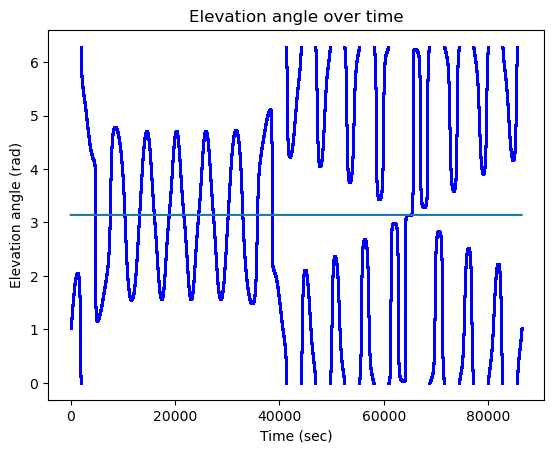

In [7]:
plt.plot(t_2,elev_angles_calc,'bs',ms=1)
plt.plot(t_2,np.pi*(np.ones(len(t_2))))
plt.title("Elevation angle over time")
plt.xlabel("Time (sec)")
plt.ylabel("Elevation angle (rad)")
plt.show()

## 1.4 Azimuth

In [8]:
print(z_1(10))

(4574527.546350656+51751.39340664466j)


In [9]:
t_1=np.linspace(0.1,24*60*60,10000)
az_angles_calc=list()
for n in t_1:
    az_angles_calc.append(azimuth(n))

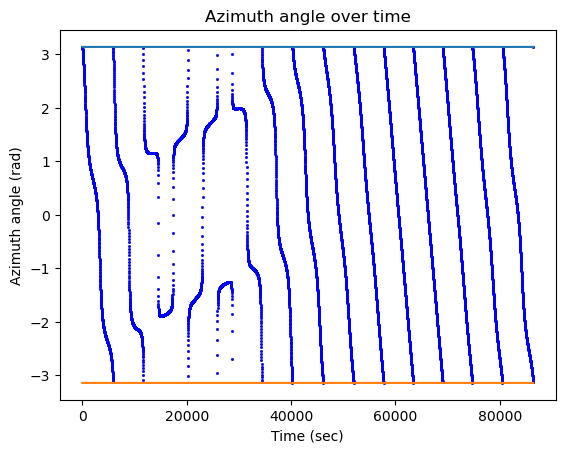

In [10]:

plt.plot(t_1,az_angles_calc,'bs',ms=1)
plt.plot(t_1,np.pi*(t_1/t_1))
plt.plot(t_1,-np.pi*(t_1/t_1))
plt.title("Azimuth angle over time")
plt.xlabel("Time (sec)")
plt.ylabel("Azimuth angle (rad)")
plt.show()

Plot both together

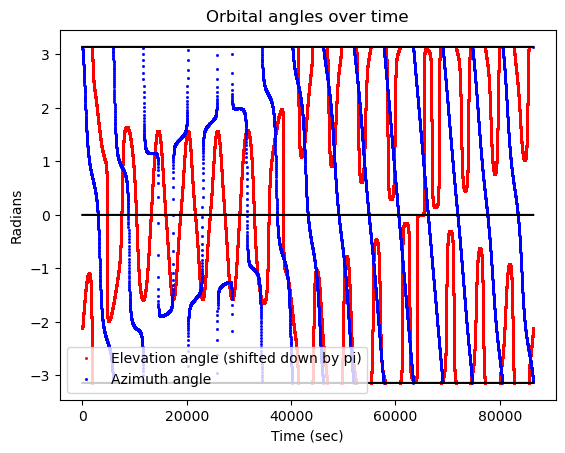

In [11]:
plt.plot(t_2,elev_angles_calc-np.ones(len(elev_angles_calc))*np.pi,'rs',ms=1,label='Elevation angle (shifted down by pi)')
plt.plot(t_1,az_angles_calc,'bs',ms=1,label='Azimuth angle')
plt.title("Orbital angles over time")
plt.xlabel("Time (sec)")
plt.ylabel("Radians")
#Plot out lines for easier viewing
plt.plot(t_1,np.pi*(t_1/t_1),'k')
plt.plot(t_1,-np.pi*(t_1/t_1),'k')
plt.plot(t_1,0*(t_1/t_1),'k')
plt.legend()
plt.show()


Eliminate times when the elevation angle is below the horizon

/var/folders/dn/8mgvm9616h162m2k9rd_y5mh0000gn/T/ipykernel_85093/702500283.py:1: RuntimeWarning: invalid value encountered in sqrt
  root=np.sqrt(elev_angles_calc-(np.ones(len(elev_angles_calc))*np.pi))


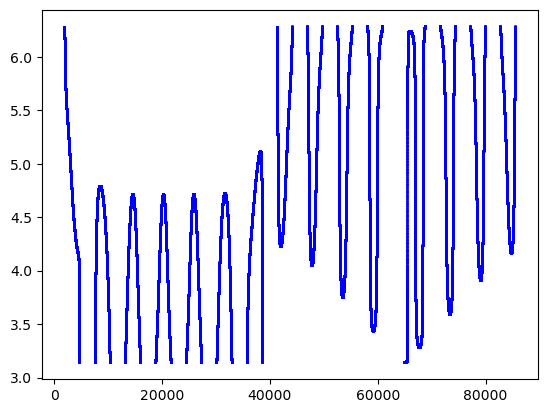

In [12]:
root=np.sqrt(elev_angles_calc-(np.ones(len(elev_angles_calc))*np.pi))
contact_elev_angles=root**2 +(np.ones(len(elev_angles_calc))*np.pi)
#corrector is a list of 1s and np.nans, with np.nan present where the sat is below horizon
corrector=contact_elev_angles/contact_elev_angles
plt.plot(t_2,contact_elev_angles,'bs',ms=1)
plt.show()

# 2.0 Slew Rates Using Astropy's Skycoord class

Here I follow the steps outlined on this tutorial https://docs.astropy.org/en/latest/coordinates/satellites.html# 

### 2.1 Imports

In [13]:
import astropy.units as u
import numpy as np
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
from sgp4.api import Satrec
from sgp4.api import SGP4_ERRORS

### 2.2 Setting up the OGS location

In [14]:
OGS=EarthLocation(lat=41.87 * u.deg, lon=-87.62 * u.deg, height=176 * u.m)
utcoffset = -5 * u.hour  # Central Daylight Time
time = Time("2024-7-12 23:00:00") - utcoffset

### 2.3 Setting up ISS position

In [15]:
s='1 25544U 98067A   24280.57443646  .00031627  00000+0  57278-3 0  9995'
t='2 25544  51.6391 123.6698 0009280  42.2498   5.0482 15.49313621475820'
satellite = Satrec.twoline2rv(s, t)
times = Time([2460588.1253356,2460588.1253356+10], format='jd')

first=True
for time in times:
    error_code, teme_p, teme_v = satellite.sgp4(time.jd1, time.jd2)  # in km and km/s
    if first:
        positions=np.array(teme_p)
        velocities=np.array(teme_v)
        first=False
        continue
    if not first:
        positions=np.stack((positions,teme_p))
        velocities=np.stack((velocities,teme_v))


x = u.Quantity(positions[:,0], u.km)
y = u.Quantity(positions[:,1], u.km)
z = u.Quantity(positions[:,2], u.km)

vx = u.Quantity(velocities[:,0], u.km)
vy = u.Quantity(velocities[:,1], u.km)
vz = u.Quantity(velocities[:,2], u.km)

from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation
car_array = CartesianRepresentation(x, y, z)
vel_car_array = CartesianDifferential((vx,vy,vz)*u.km/u.s)

print(car_array,vel_car_array)
#if error_code != 0:
#    raise RuntimeError(SGP4_ERRORS[error_code])

[(-2433.71696243, 5730.88155379, -2728.54560568),
 ( 1563.31193424, 6526.89027741, -1071.07770208)] km [(-5.65598767, 0.04464897, 5.16405049),
 (-4.46443581, 2.02247195, 5.88807411)] km / s


### 2.41 Finding alt and az with skyCoord object

In [16]:

print(vel_car_array[0])

(-5.65598767, 0.04464897, 5.16405049) km / s


In [17]:

#c = SkyCoord(x=588,y=1853,z=-2173, U=vx, V=vy, W=vz,unit='km',obstime=time,frame='teme',differential_type=CartesianDifferential)
#c = SkyCoord(x=teme_p[0],y=teme_p[1],z=teme_p[2],unit='km',obstime=time,frame='teme')
c = SkyCoord(car_array,unit='km',obstime=time,frame='teme')

In [18]:
altaz = c.transform_to(AltAz(obstime=time, location=OGS))
from astropy.coordinates import Angle
#print(altaz.alt.deg)
print("Altitude =", altaz.alt.deg)
print("Azimuth =", altaz.az.deg)

Altitude = [-37.4091421  -44.25684285]
Azimuth = [224.11041987 259.84952435]


In [19]:
#altaz

### 2.42 Finding alt and az with TEME object

In [20]:
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation
from astropy import units as u
teme_p = CartesianRepresentation(teme_p*u.km)
teme_v = CartesianDifferential(teme_v*(u.km/u.s))
teme = TEME(teme_p.with_differentials(teme_v), obstime=time)

The intermediate step of manually setting up a topocentric ITRS frame is necessary in order to avoid the change in stellar aberration that would occur if a direct transform from geocentric to topocentric coordinates using transform_to was used. Please see the documentation of the ITRS frame for more details.

In [21]:
from astropy.coordinates import ITRS
itrs_geo = teme.transform_to(ITRS(obstime=time))

In [22]:
from astropy.coordinates import EarthLocation, AltAz
#siding_spring = EarthLocation.of_site('aao')  
topo_itrs_repr = itrs_geo.cartesian.without_differentials() - OGS.get_itrs(time).cartesian
itrs_topo = ITRS(topo_itrs_repr, obstime = time, location=OGS)
aa = itrs_topo.transform_to(AltAz(obstime=time, location=OGS))
print(f"Altitude = {aa.alt:.2}")
print(f"Azimuth = {aa.az:.2}")

Altitude = -4.4e+01 deg
Azimuth = 2.6e+02 deg


## 2.5 Now to plot out alt and az over time

### 2.51 writing function that generates altaz coordinates 

In [23]:
def ISS_alt_az(observatory_loc,time_start,time_end,time_num,LE2=['1 25544U 98067A   24280.57443646  .00031627  00000+0  57278-3 0  9995'
,'2 25544  51.6391 123.6698 0009280  42.2498   5.0482 15.49313621475820']):
    # Set up satrack
    ISS_track= Satrec.twoline2rv(LE2[0], LE2[1])
    #Set up times
    times = Time(np.linspace(time_start,time_end,num=time_num), format='jd')
    dt=Time(np.linspace(0,(time_end-time_start).sec,num=time_num), format='jd')
    #Go through times
    first=True
    for time in times:
        error_code, teme_p, teme_v = satellite.sgp4(time.jd1, time.jd2)  # in km and km/s
        if first:
            positions=np.array([teme_p])
            velocities=np.array([teme_v])
            first=False
            continue
        if not first:
            positions=np.concatenate((positions,np.array([teme_p])),axis=0)
            velocities=np.concatenate((velocities,np.array([teme_v])),axis=0)
    #Set up cartesian representation
    x = u.Quantity(positions[:,0], u.km)
    y = u.Quantity(positions[:,1], u.km)
    z = u.Quantity(positions[:,2], u.km)
    car_array = CartesianRepresentation(x, y, z)
    #Set up the skycoord object
    c = SkyCoord(car_array,unit='km',obstime=times,frame='teme')
    #Now transform to altaz coordinates
    altaz = c.transform_to(AltAz(obstime=times, location=OGS))
    return(altaz,times,dt)

In [24]:
#time = Time("2024-7-12 23:00:00") - utcoffset
#time_start,time_end,time_num=time,time+2*24*60*60*u.s,10000
#times=Time(np.linspace(0,(time_end-time_start).sec,num=time_num), format='jd')

#print(times.FORMATS.keys())
#print(type(times.datetime64))
#print(times.to_value(format='jd'))

In [25]:
#set up OGS time and position
OGS=EarthLocation(lat=41.87 * u.deg, lon=-87.62 * u.deg, height=176 * u.m)
utcoffset = -5 * u.hour  # Central Daylight Time
time = Time("2024-7-12 23:00:00") - utcoffset

time.format = 'cxcsec'

days=20
altaz,times,dt=ISS_alt_az(OGS,time,time+20*24*u.h,int(days*10000/2))



In [26]:
print(altaz)
#Put time in days
numpy_times=times.to_value(format='jd')
numpy_time_delta=numpy_times-numpy_times[0]
print(numpy_time_delta)

<SkyCoord (AltAz: obstime=[2460504.66666667 2460504.66686667 2460504.66706667 ... 2460524.66626666
 2460524.66646666 2460524.66666667], location=(197534.27322157, -4752676.40465835, 4234979.81653322) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, km)
    [(341.74486711,  16.94714254, 1166.34281722),
     (348.27870595,  17.23139632, 1154.79635529),
     (354.8803271 ,  17.20471607, 1155.89531439), ...,
     (265.13704677, -12.97992157, 4202.5377884 ),
     (263.38573846, -12.84795279, 4180.13807749),
     (261.61816366, -12.73366795, 4160.67977652)]>
[0.00000000e+00 2.00001989e-04 4.00003977e-04 ... 1.99996000e+01
 1.99998000e+01 2.00000000e+01]


### Plot it out

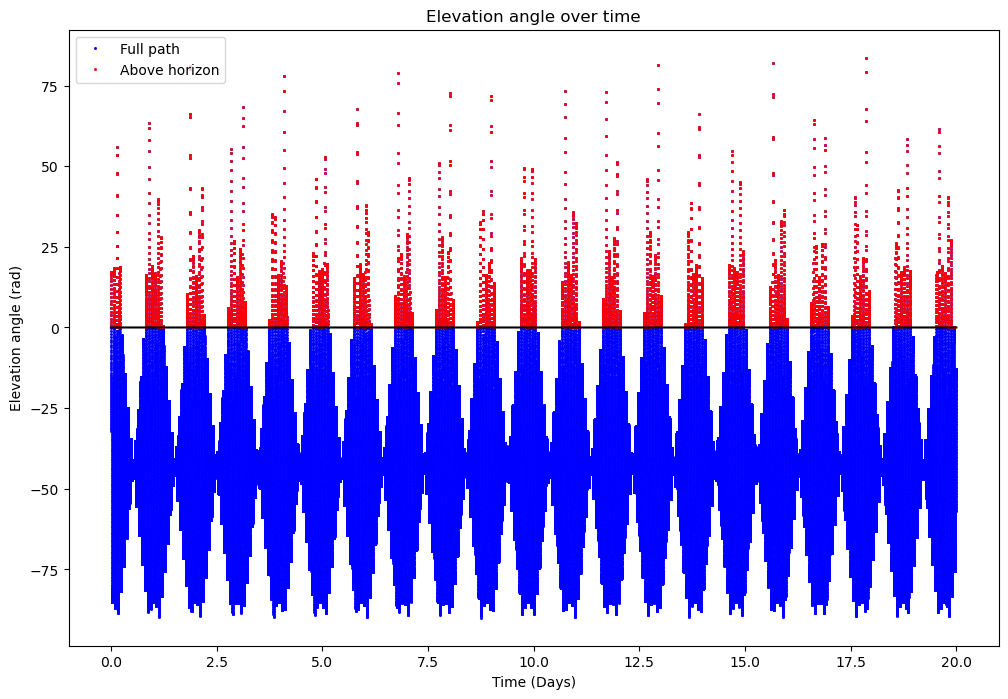

In [27]:
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from astropy.visualization import time_support
import numpy.ma as ma


with quantity_support() and time_support():
    plt.figure(figsize=(12,8))
    plt.plot(numpy_time_delta,altaz.alt.deg,'bs',ms=1,label='Full path')
    above_horizon=np.ma.masked_less(altaz.alt.deg,0)
    above_horizon_mask=np.ma.getmask(above_horizon)
    plt.plot(numpy_time_delta,above_horizon,'rs',ms=1,label='Above horizon')
    #plt.plot(times,(np.pi/2)*np.ones(len(times)))
    plt.plot(numpy_time_delta,(0)*np.ones(len(times)),'k')
    plt.title("Elevation angle over time")
    plt.xlabel("Time (Days)")
    plt.ylabel("Elevation angle (rad)")
    plt.legend(loc='upper left')
    plt.show()

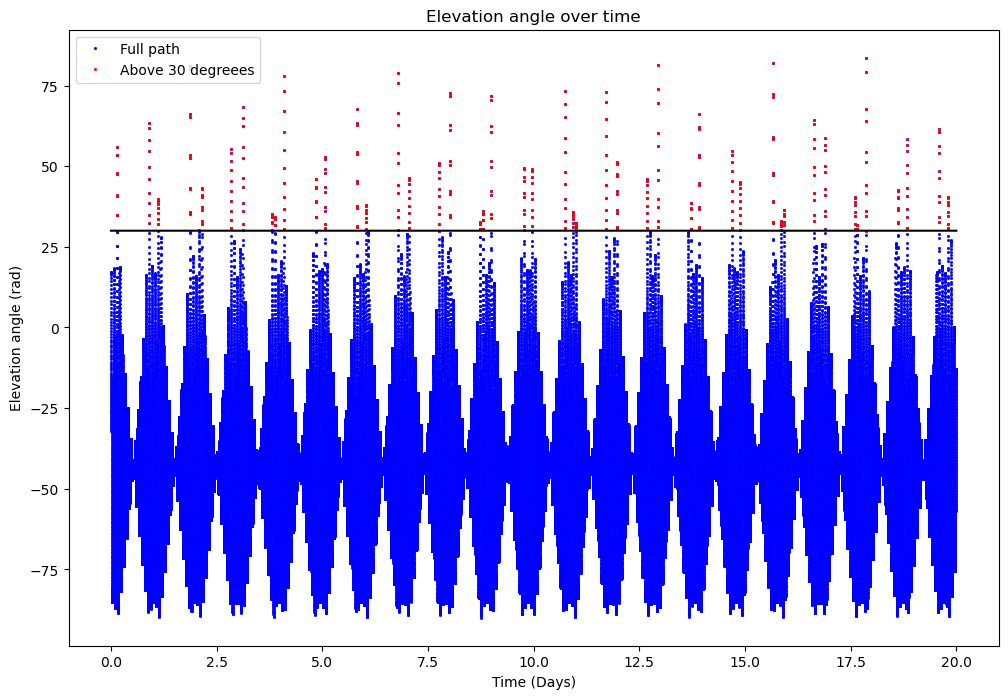

In [28]:
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from astropy.visualization import time_support
import numpy.ma as ma
deg_threshold=30

with quantity_support() and time_support():
    plt.figure(figsize=(12,8))
    plt.plot(numpy_time_delta,altaz.alt.deg,'bs',ms=1,label='Full path')
    above_horizon=np.ma.masked_less(altaz.alt.deg,deg_threshold)
    above_horizon_mask=np.ma.getmask(above_horizon)
    plt.plot(numpy_time_delta,above_horizon,'rs',ms=1,label=f'Above {deg_threshold} degreees')
    #plt.plot(times,(np.pi/2)*np.ones(len(times)))
    plt.plot(numpy_time_delta,(deg_threshold)*np.ones(len(times)),'k')
    plt.title("Elevation angle over time")
    plt.xlabel("Time (Days)")
    plt.ylabel("Elevation angle (rad)")
    plt.legend(loc='upper left')
    #for peak in peaks:
        #plt.axvline(x=numpy_time_delta[peak],lw=1)
    plt.show()

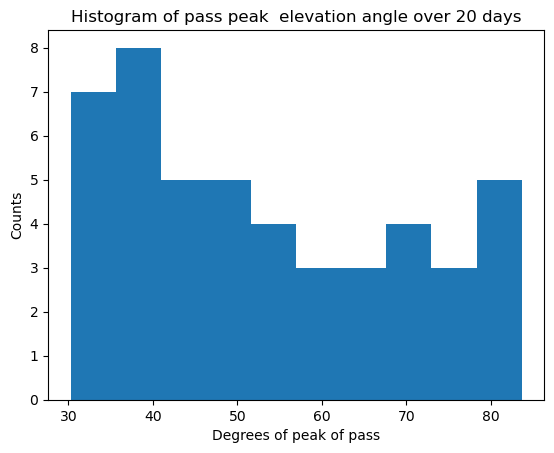

[-- -- 55.9079002009454 -- -- -- -- -- -- -- -- -- -- --
 63.503078699543615 -- -- 39.706895299205435 -- -- -- -- -- -- -- -- -- --
 -- 81.18160762806454 -- -- 30.270681296807044 43.141175187965004 -- -- --
 -- -- -- -- -- -- -- 55.22935244450974 -- -- -- 68.46314541154474 -- --
 -- -- -- -- -- -- -- -- 35.265458093882124 34.21272896233194 -- --
 78.01835493176519 -- -- -- -- -- -- -- -- -- -- -- 46.13063107601695 --
 -- 52.74691774915186 -- -- -- -- -- -- -- -- -- -- -- 67.6984707691598 --
 -- 37.88983428036026 -- -- -- -- -- -- -- -- -- -- -- 79.02192433966144
 -- -- -- 46.44488965298932 -- -- -- -- -- -- -- -- -- --
 51.090544700456775 -- -- -- 72.54324159090802 -- -- -- -- -- -- -- -- --
 -- 32.6778368121082 36.04856422837532 -- -- 71.8427423857872 -- -- -- --
 -- -- -- -- -- -- -- 49.54210316336528 -- -- 49.19964555239272 -- -- --
 -- -- -- -- -- -- -- -- 73.29074116678095 -- -- 35.65916524014603
 32.504886095049464 -- -- -- -- -- -- -- -- -- -- 73.01675549631082 -- --
 -- 51.1479

In [29]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(above_horizon)
plt.hist(above_horizon[peaks])
plt.title("Histogram of pass peak  elevation angle over 20 days")
plt.xlabel("Degrees of peak of pass")
plt.ylabel("Counts")
plt.show()
print(above_horizon[peaks])

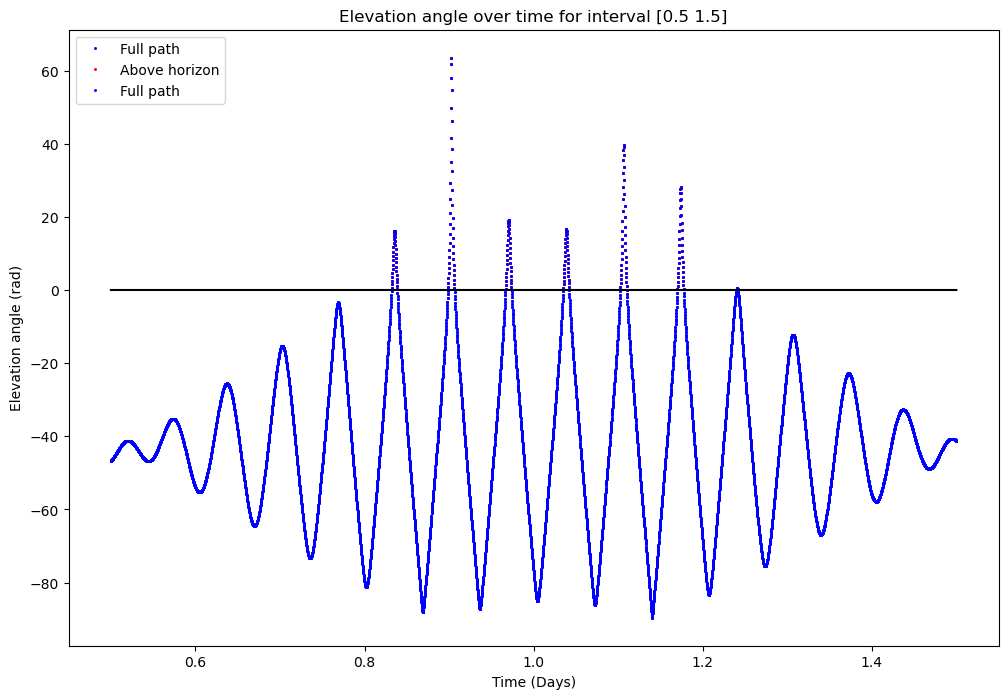

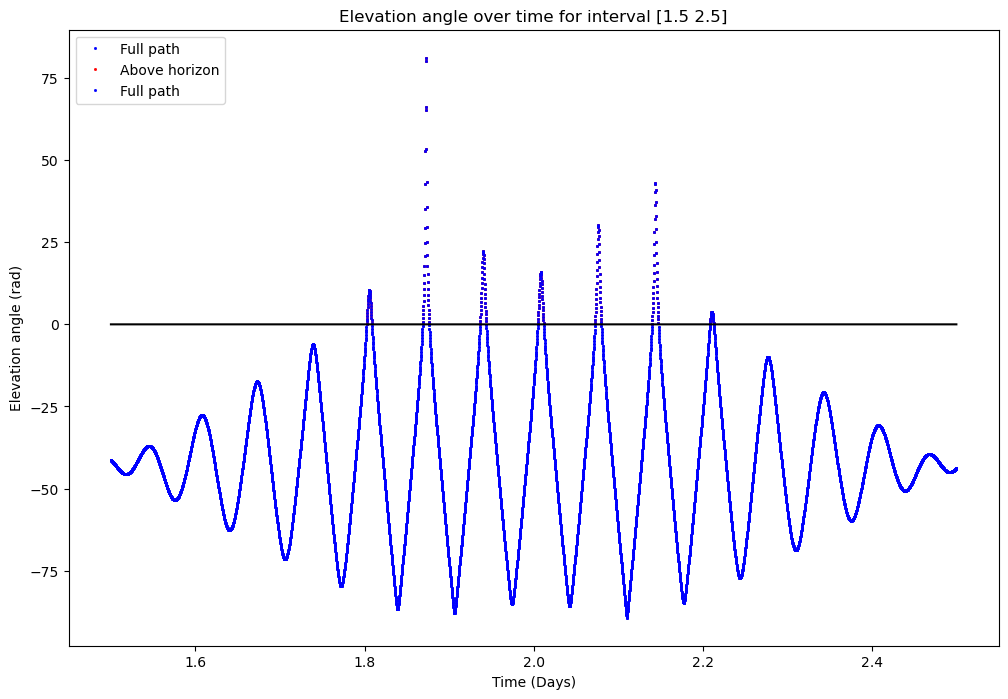

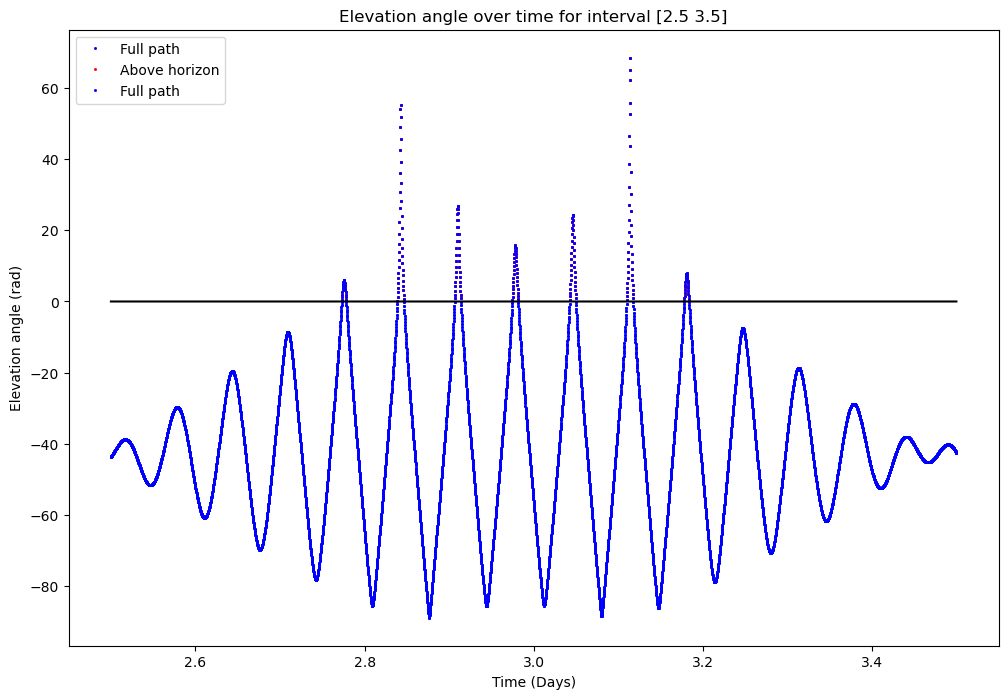

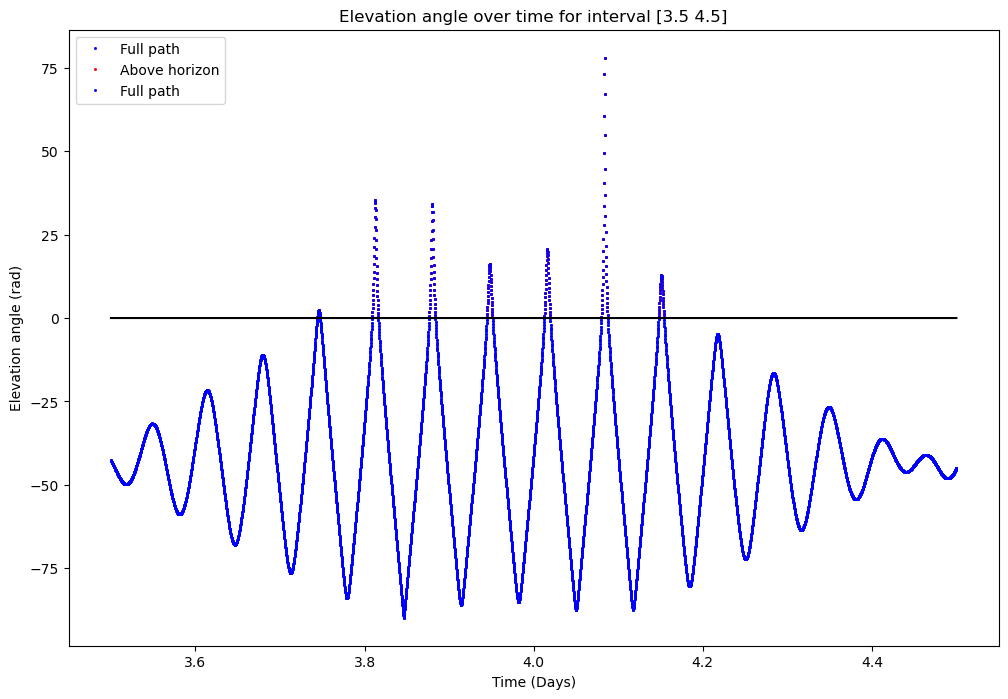

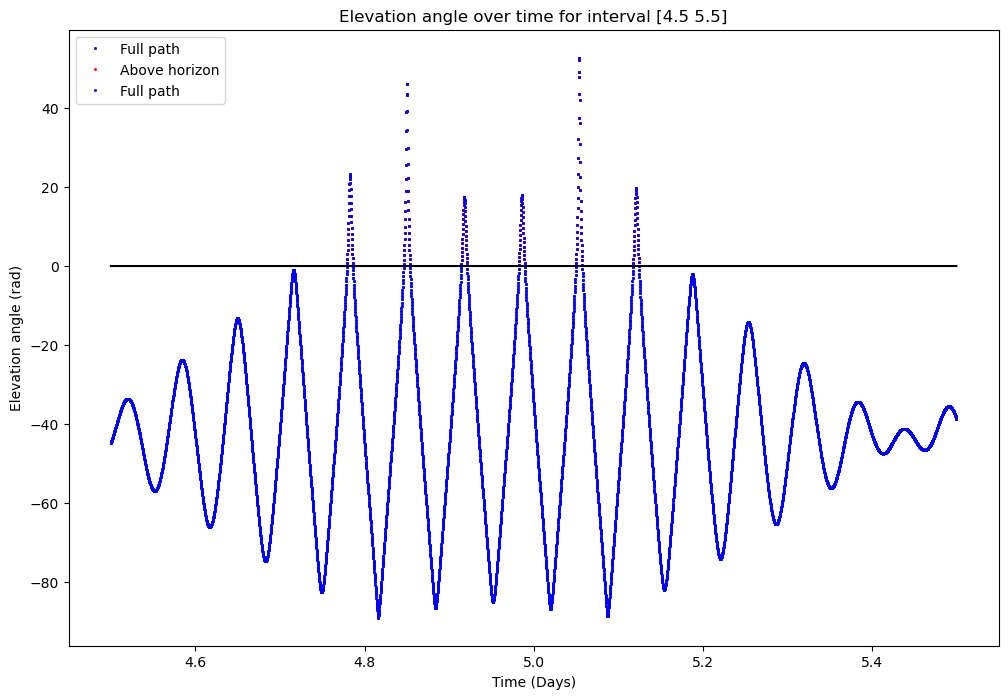

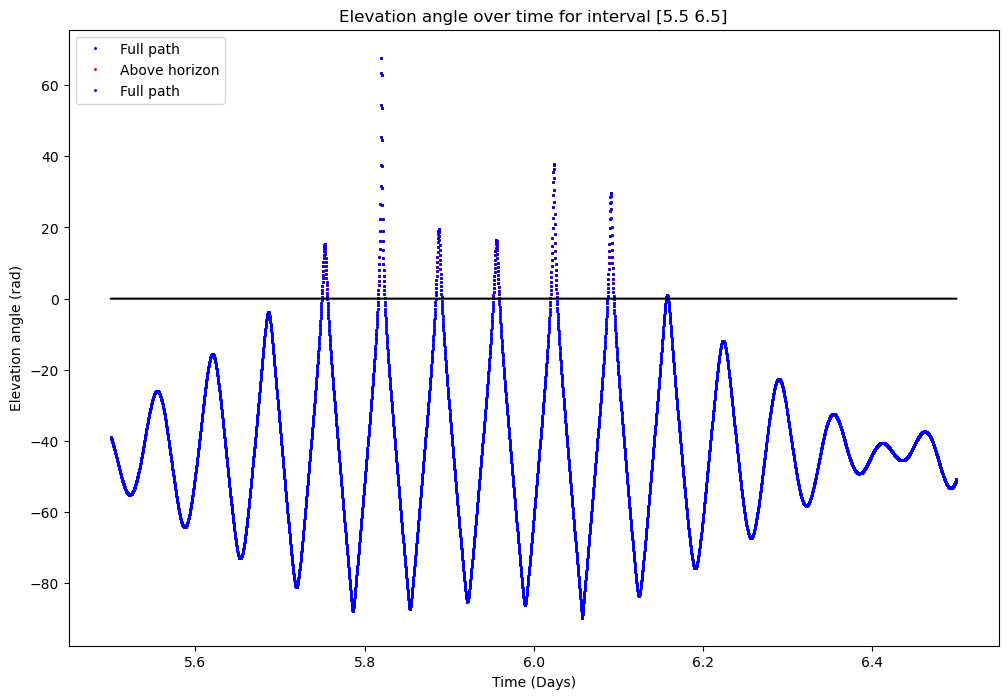

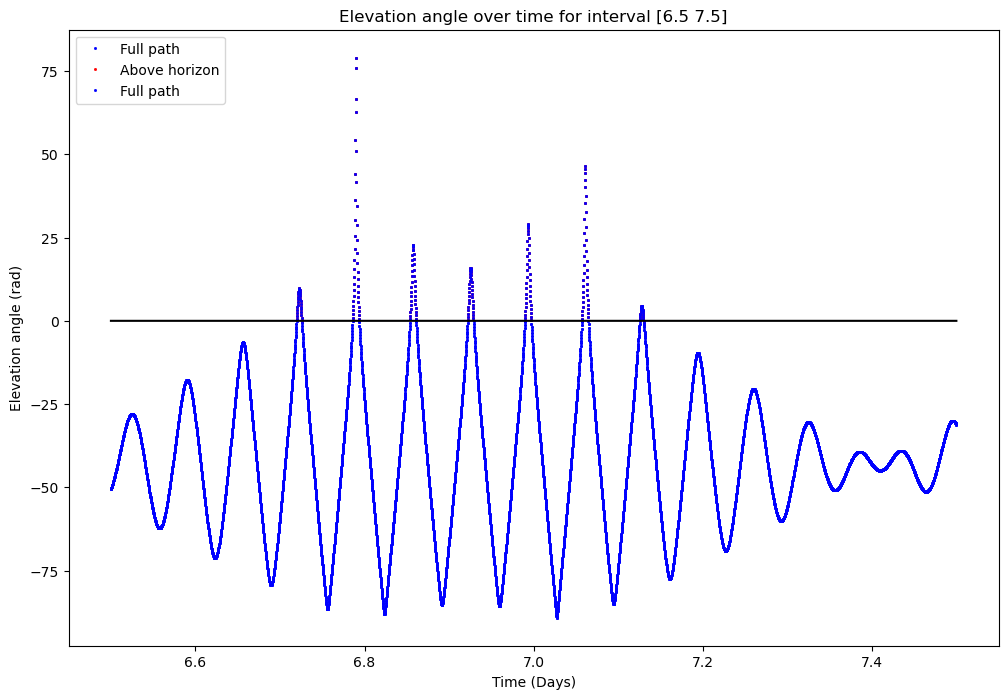

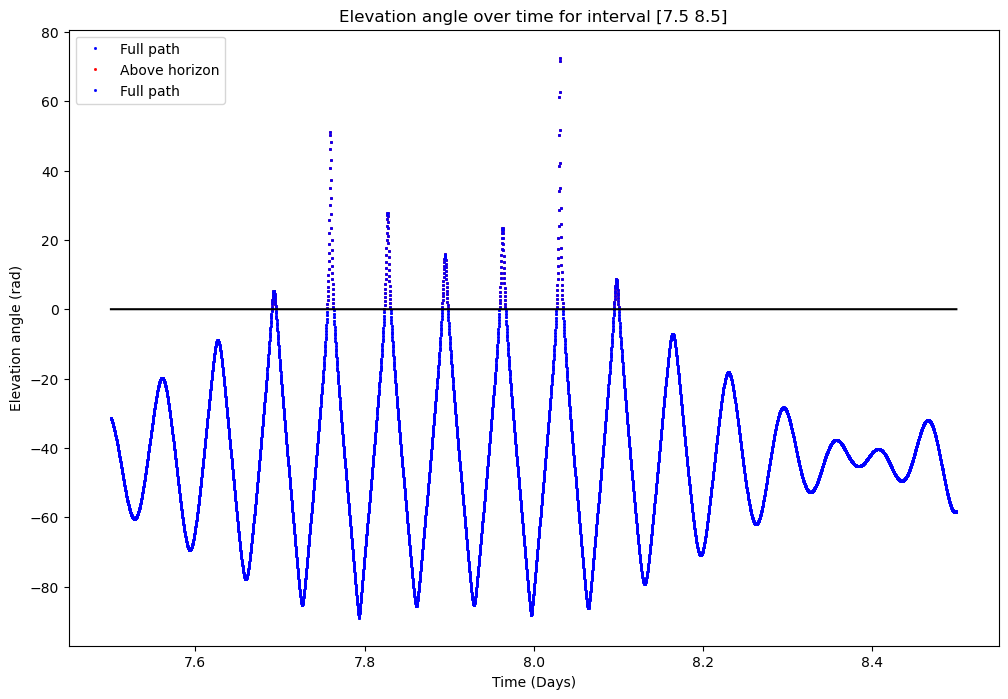

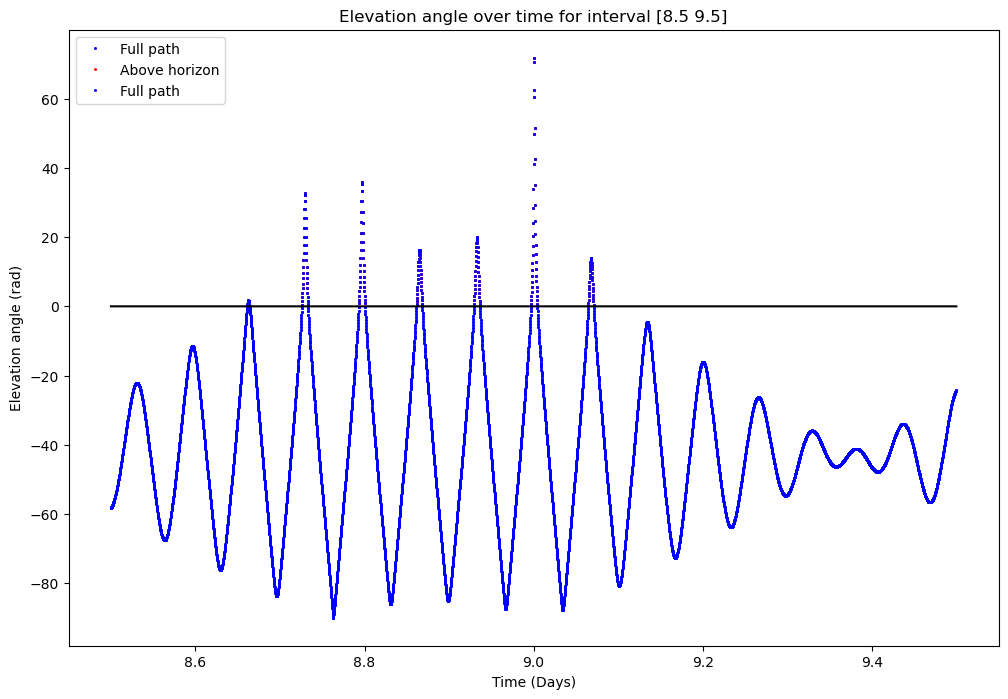

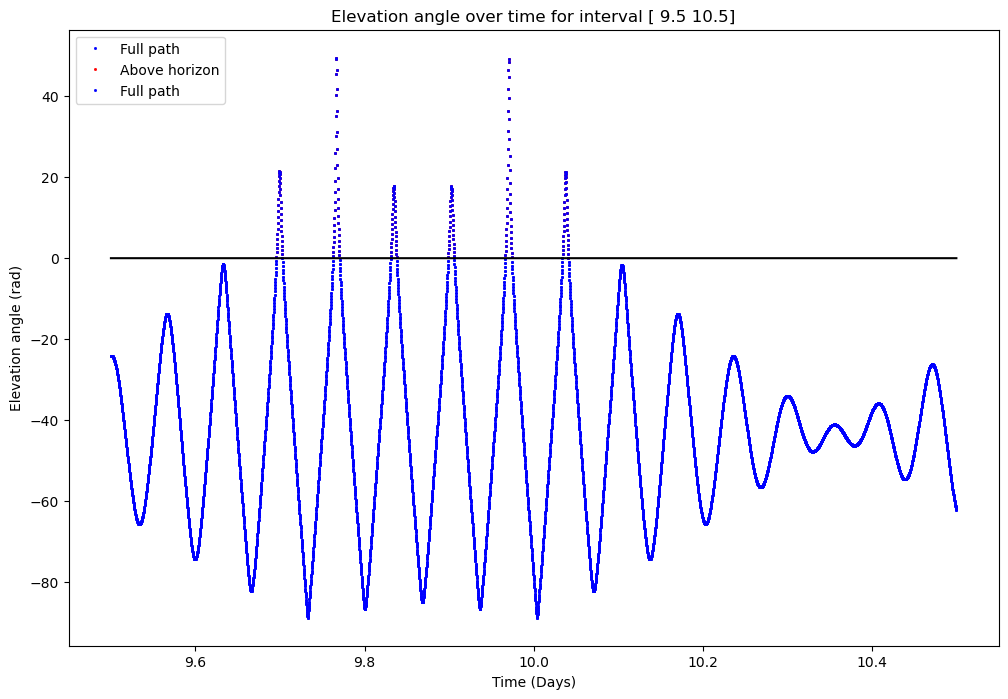

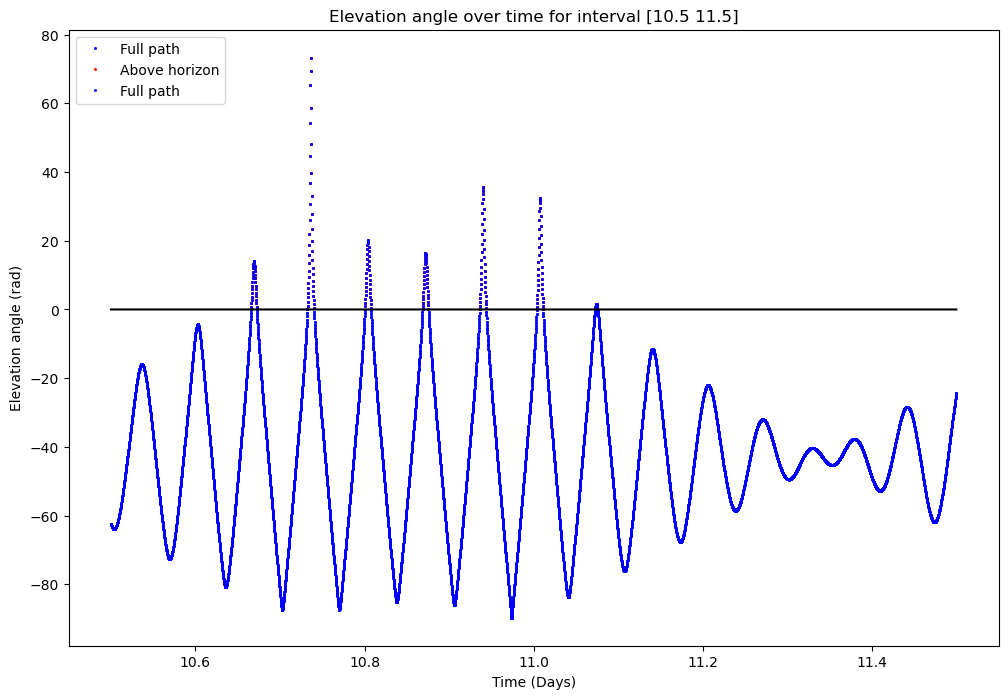

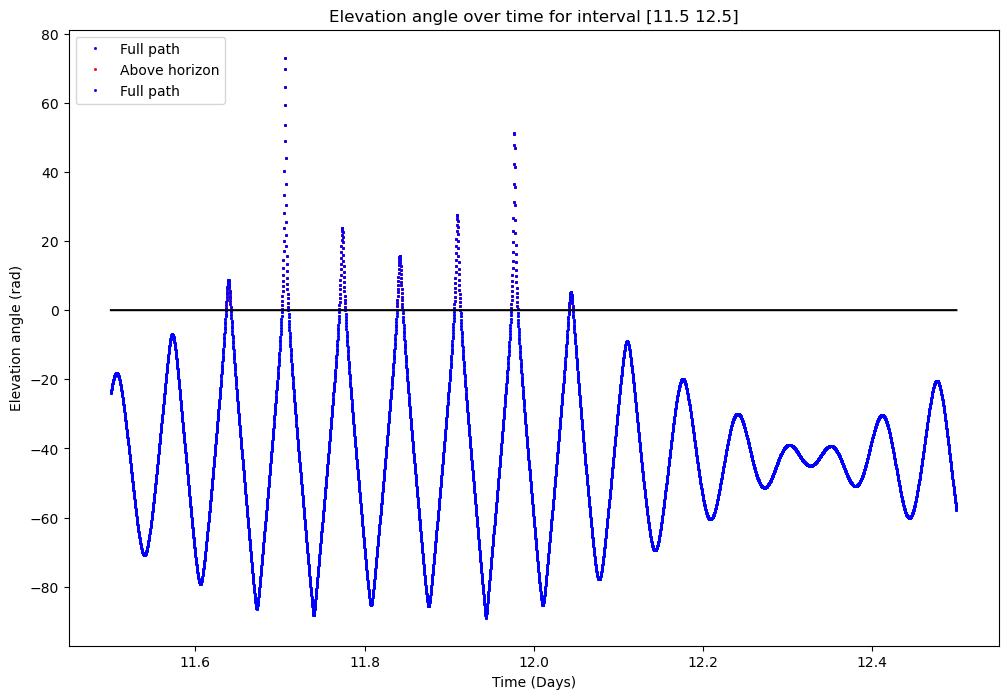

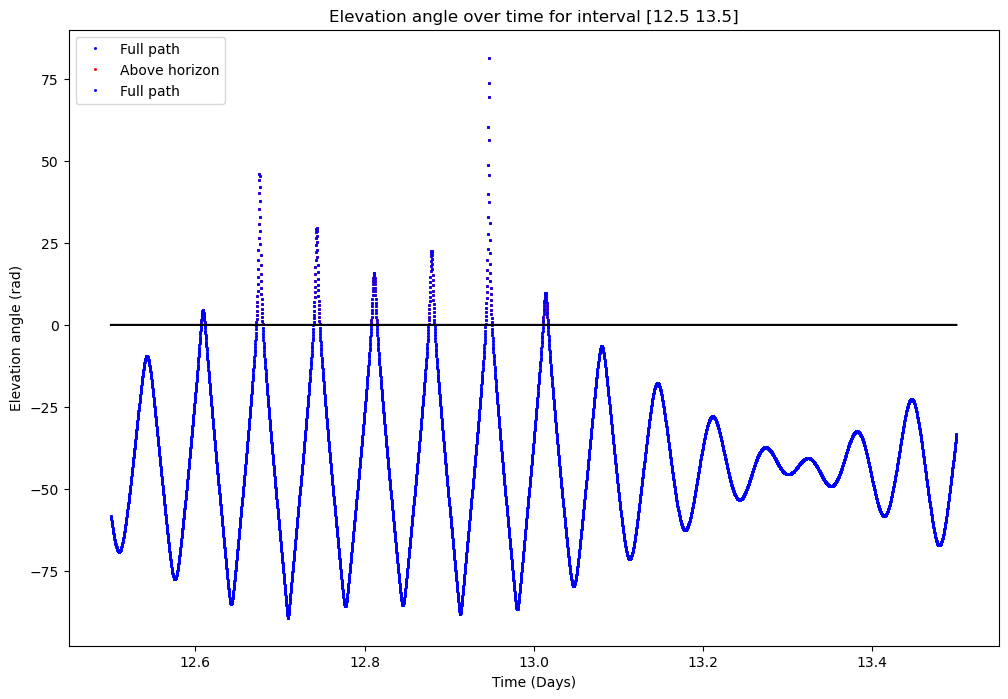

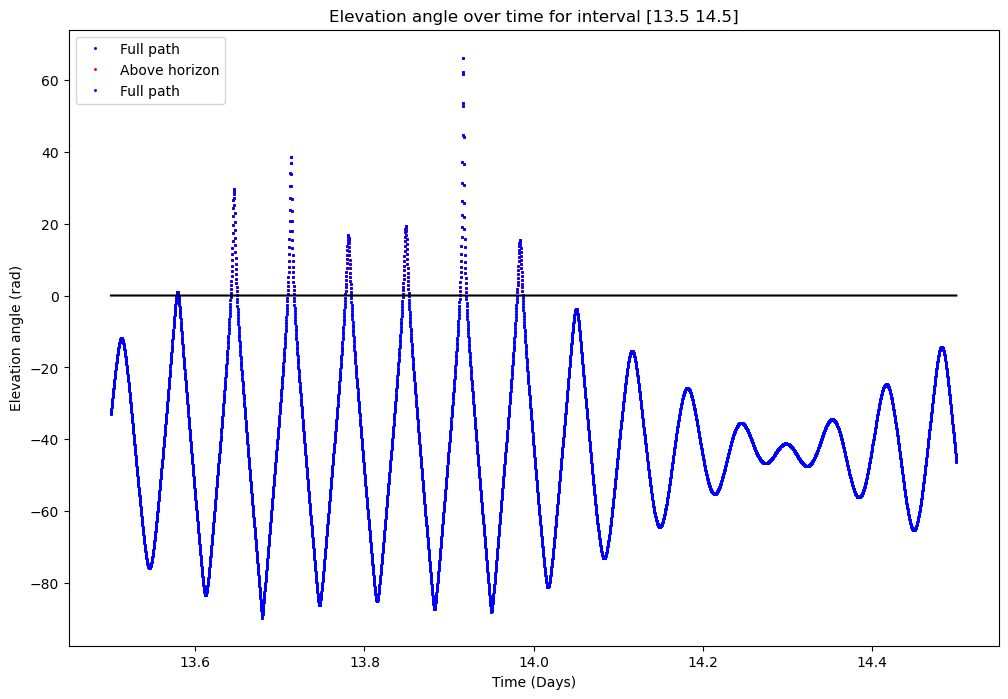

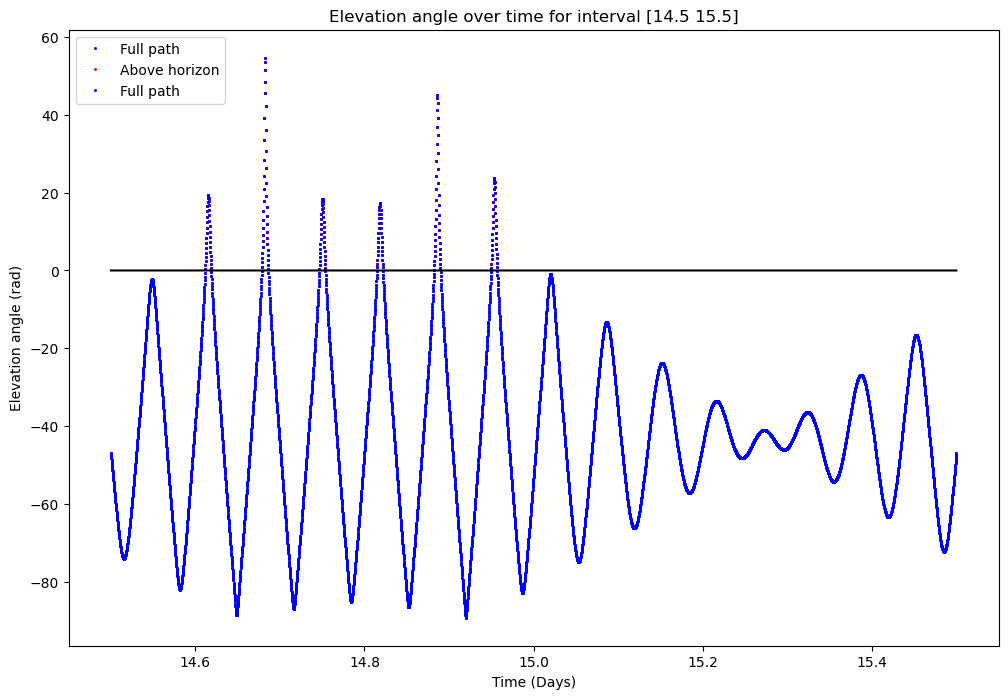

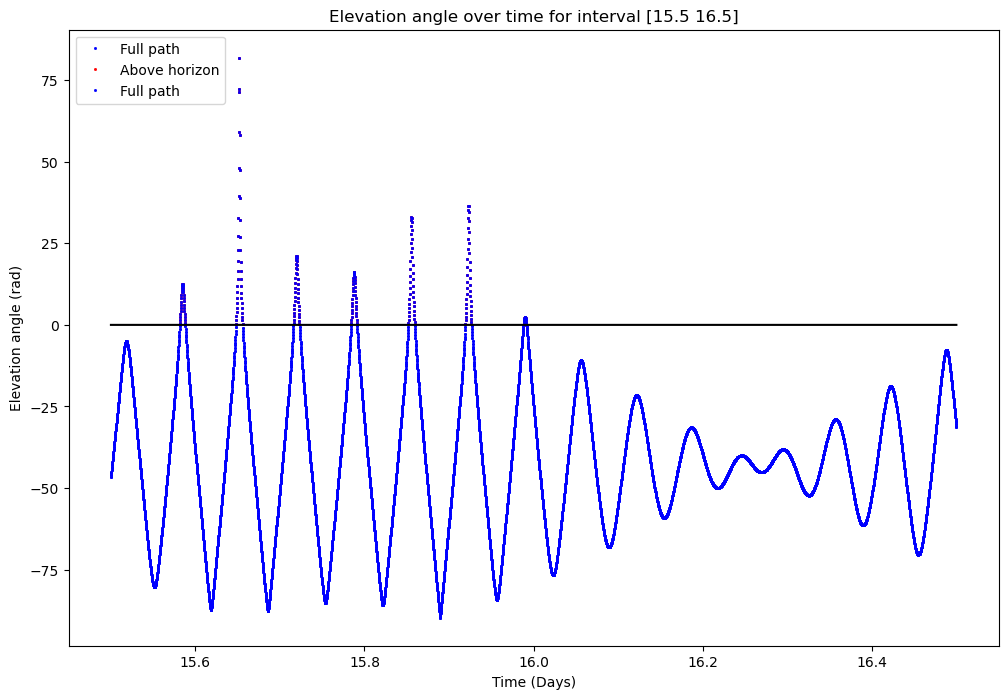

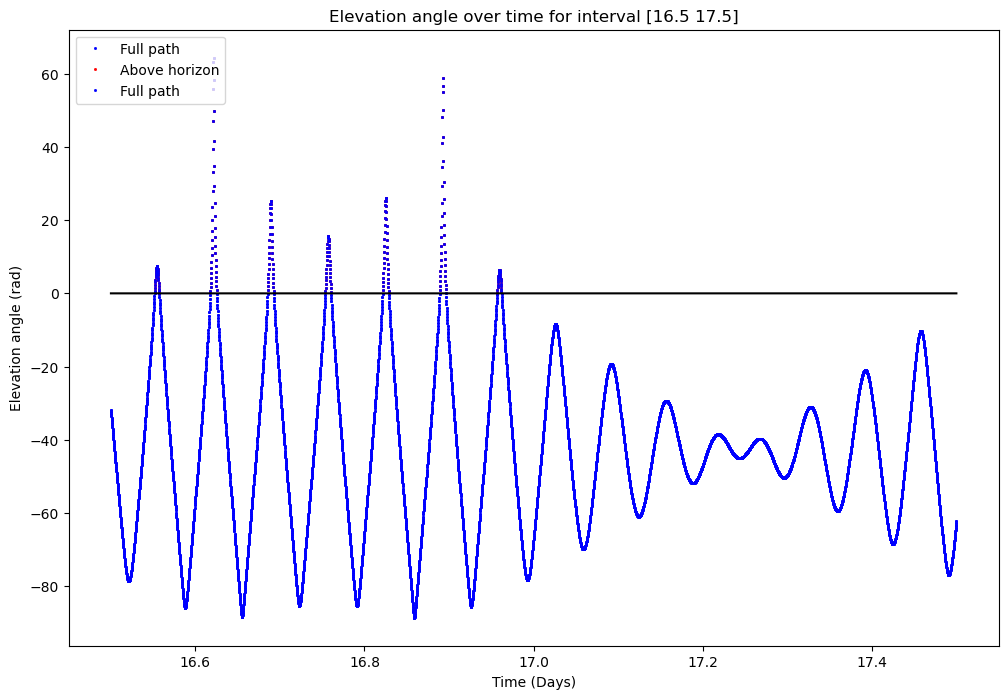

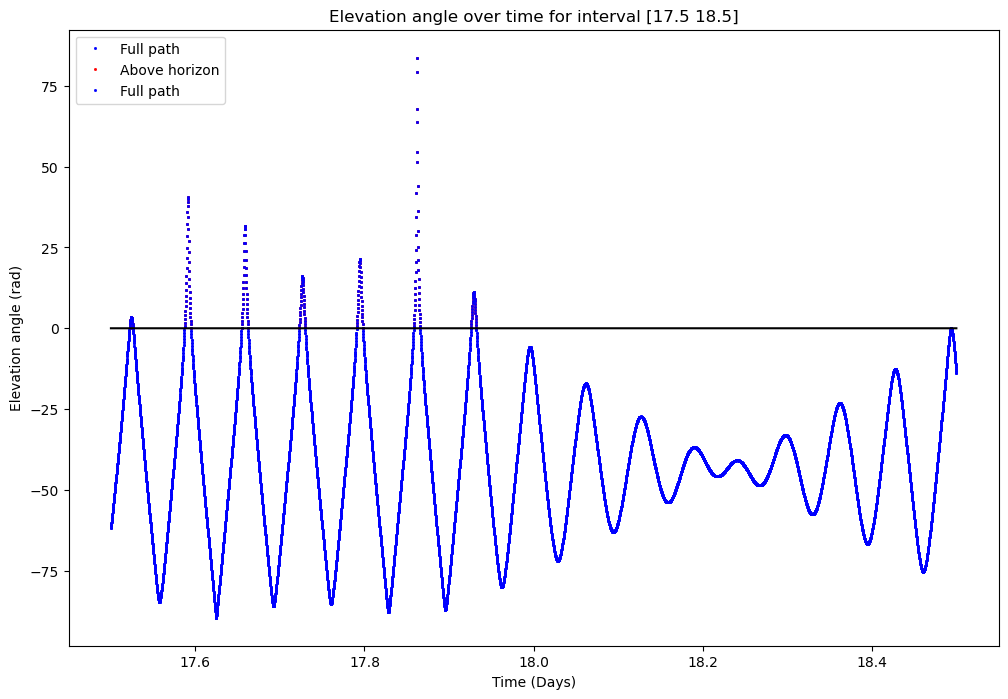

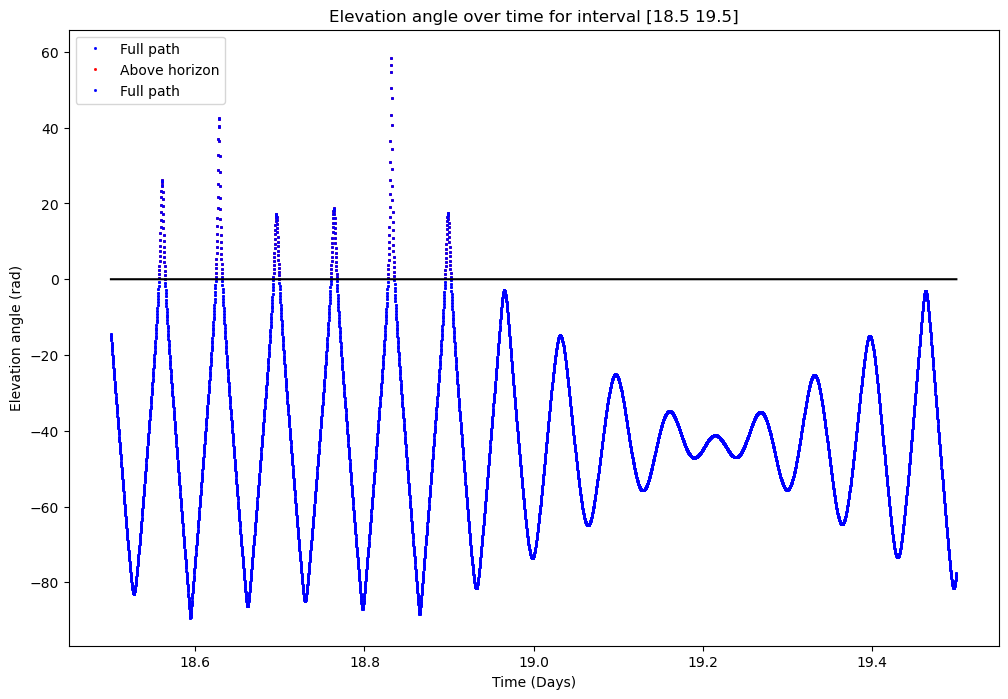

In [30]:
with quantity_support() and time_support():
    
    intervals_start=0.5+np.arange(19)
    intervals_end=1.5+np.arange(19)
    intervals=np.stack((intervals_start,intervals_end),axis=1)
    #print(intervals)
    for interval in intervals:
        plt.figure(figsize=(12,8))
        above_horizon=np.ma.masked_less(altaz.alt.deg,0)
        above_horizon_mask=np.ma.getmask(above_horizon)
        boolean_arr=(numpy_time_delta>(np.ones_like(numpy_time_delta))*interval[0]) * ((np.ones_like(numpy_time_delta)*numpy_time_delta)<interval[1])
        plt.plot(numpy_time_delta[boolean_arr],altaz.alt.deg[boolean_arr],'bs',ms=1,label='Full path')
        plt.plot(numpy_time_delta[boolean_arr],above_horizon[boolean_arr],'rs',ms=1,label='Above horizon')
        plt.plot(numpy_time_delta[boolean_arr],altaz.alt.deg[boolean_arr],'bs',ms=1,label='Full path')
        plt.plot(numpy_time_delta[boolean_arr],(0)*np.ones(len(numpy_time_delta[boolean_arr])),'k')
        plt.title(f"Elevation angle over time for interval {interval}")
        plt.xlabel("Time (Days)")
        plt.ylabel("Elevation angle (rad)")
        plt.legend(loc='upper left')
        plt.show()

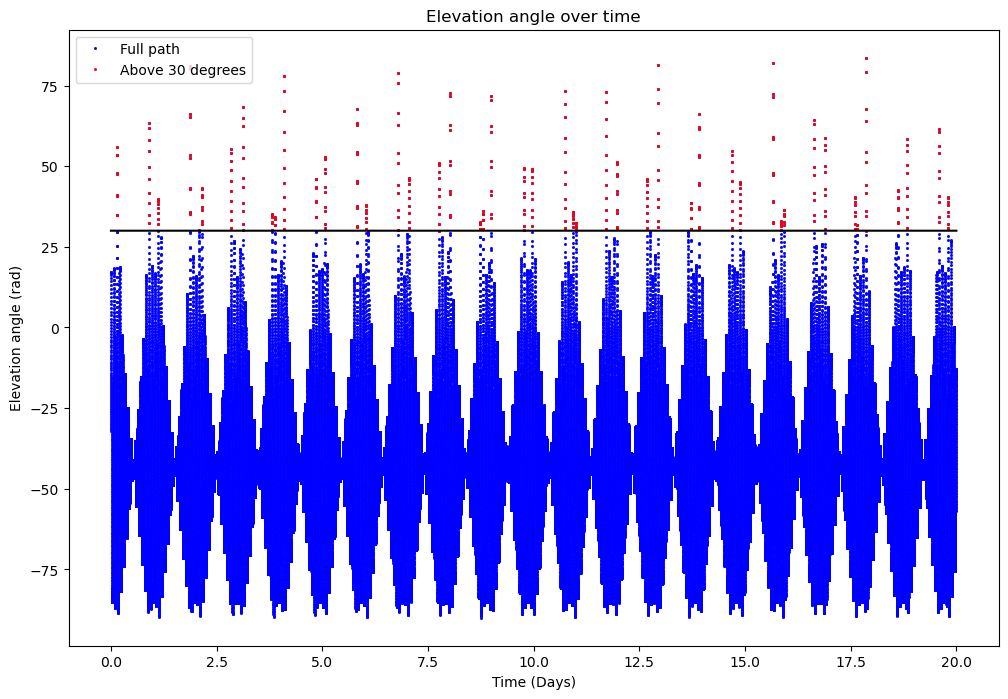

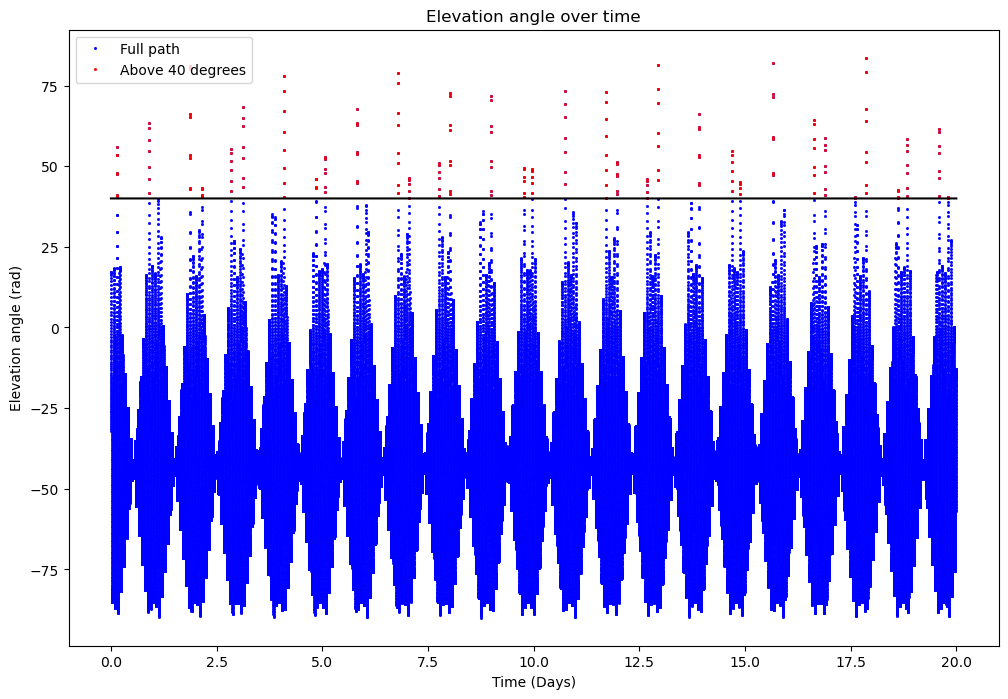

In [31]:
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from astropy.visualization import time_support
import numpy.ma as ma
deg_threshold=30

with quantity_support() and time_support():
    plt.figure(figsize=(12,8))
    plt.plot(numpy_time_delta,altaz.alt.deg,'bs',ms=1,label='Full path')
    above_horizon=np.ma.masked_less(altaz.alt.deg,deg_threshold)
    above_horizon_mask=np.ma.getmask(above_horizon)
    plt.plot(numpy_time_delta,above_horizon,'rs',ms=1,label=f'Above {deg_threshold} degrees')
    #plt.plot(times,(np.pi/2)*np.ones(len(times)))
    plt.plot(numpy_time_delta,(deg_threshold)*np.ones(len(times)),'k')
    plt.title("Elevation angle over time")
    plt.xlabel("Time (Days)")
    plt.ylabel("Elevation angle (rad)")
    plt.legend(loc='upper left')
    plt.show()
deg_threshold=40

with quantity_support() and time_support():
    plt.figure(figsize=(12,8))
    plt.plot(numpy_time_delta,altaz.alt.deg,'bs',ms=1,label='Full path')
    above_horizon=np.ma.masked_less(altaz.alt.deg,deg_threshold)
    above_horizon_mask=np.ma.getmask(above_horizon)
    plt.plot(numpy_time_delta,above_horizon,'rs',ms=1,label=f'Above {deg_threshold} degrees')
    #plt.plot(times,(np.pi/2)*np.ones(len(times)))
    plt.plot(numpy_time_delta,(deg_threshold)*np.ones(len(times)),'k')
    plt.title("Elevation angle over time")
    plt.xlabel("Time (Days)")
    plt.ylabel("Elevation angle (rad)")
    plt.legend(loc='upper left')
    plt.show()

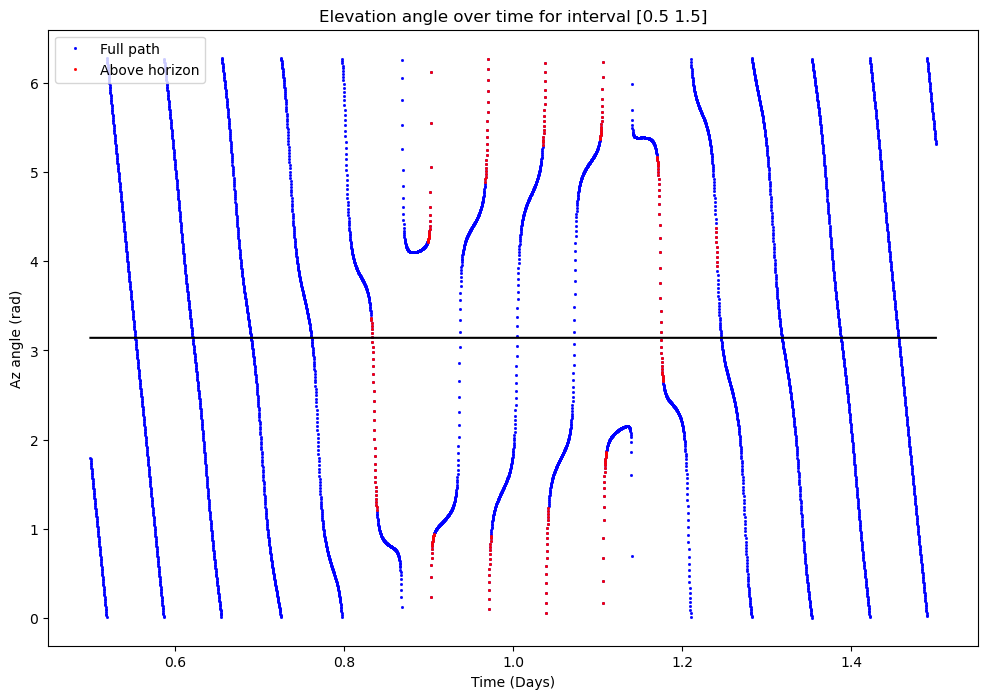

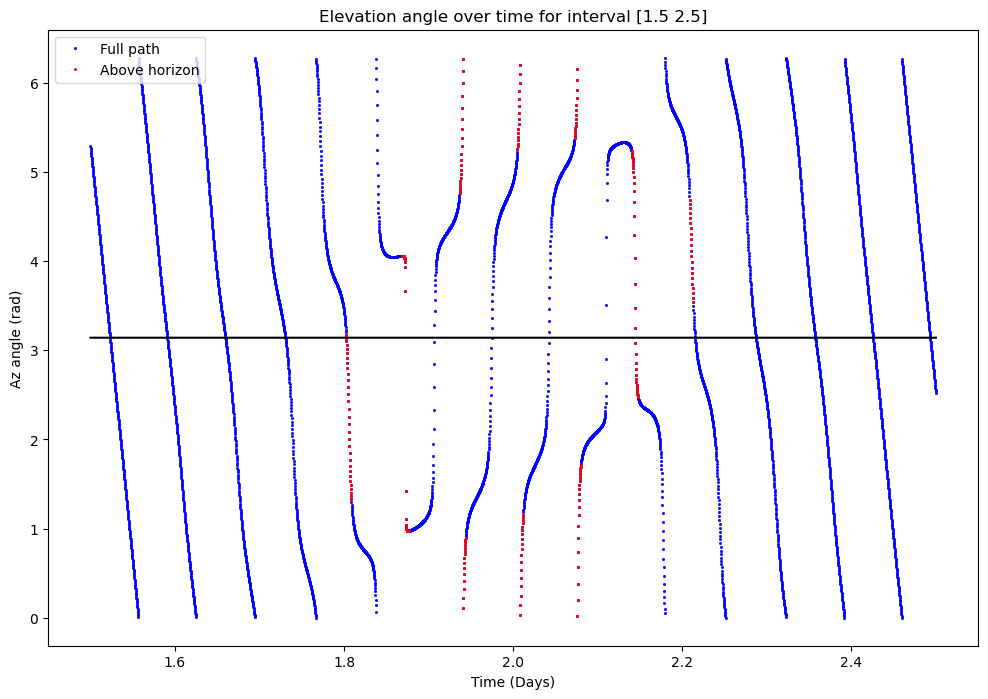

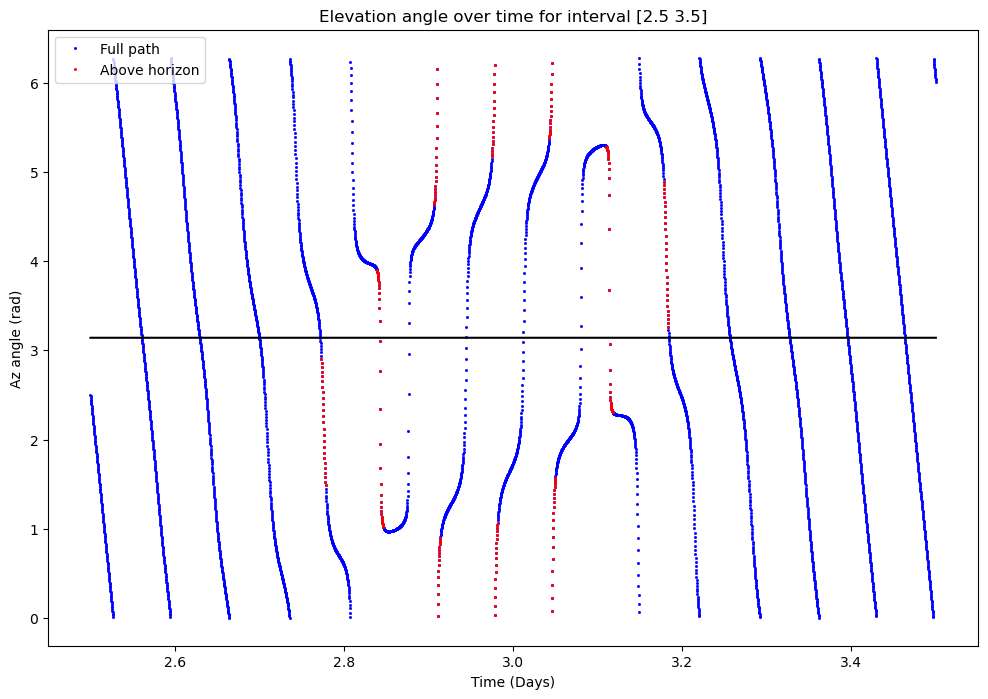

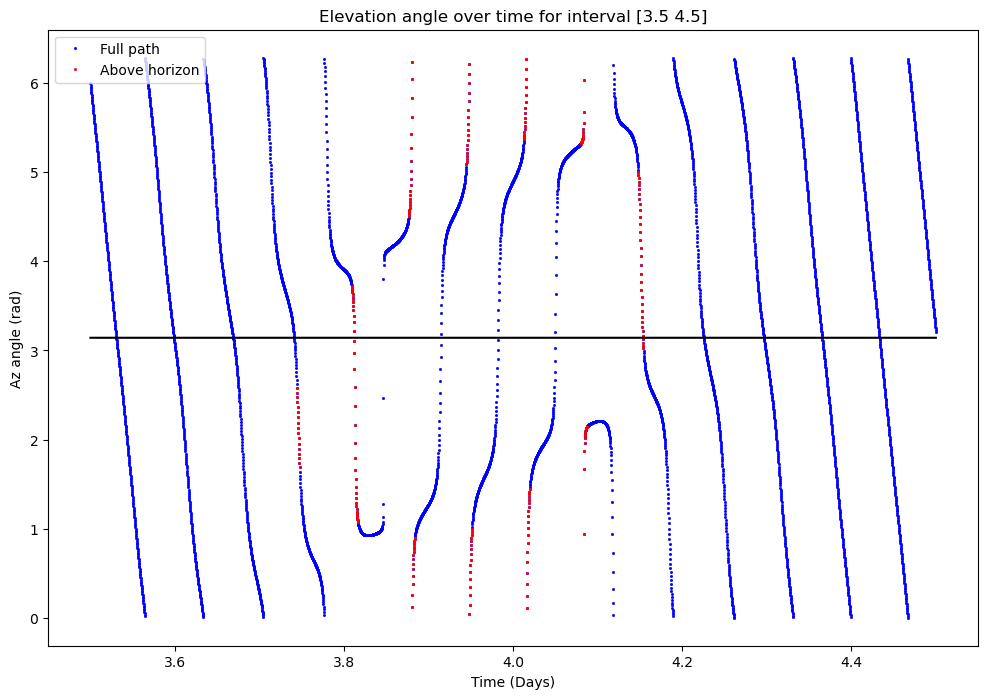

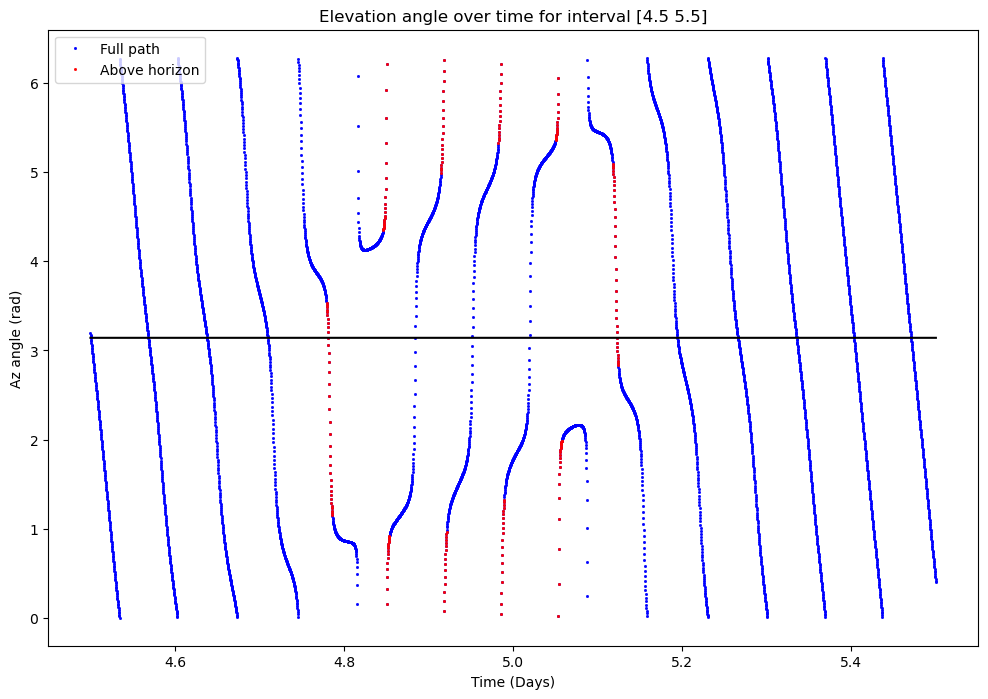

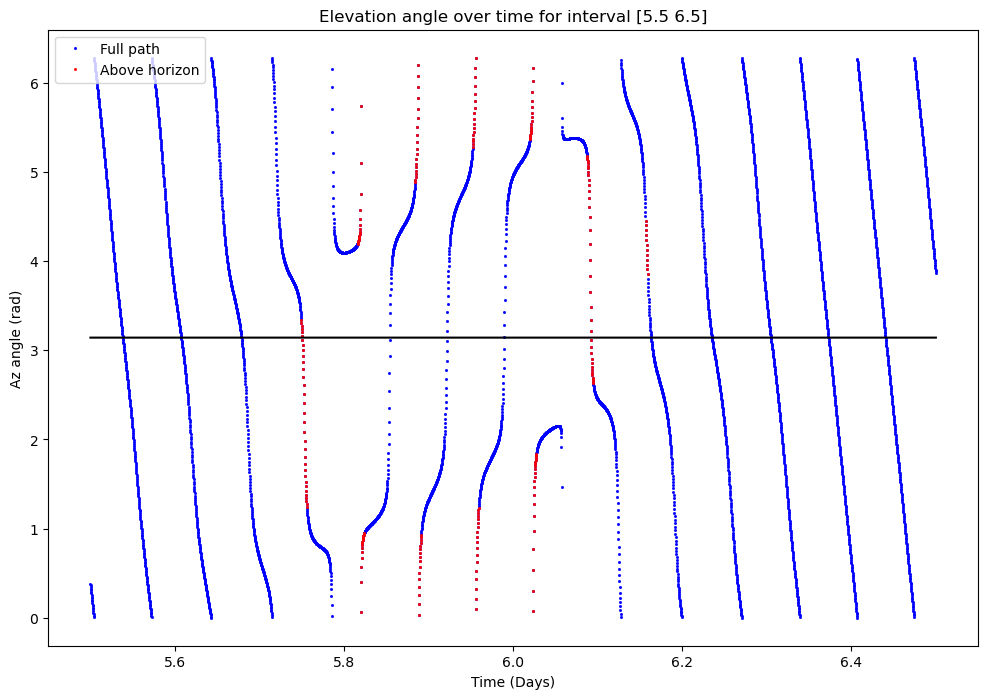

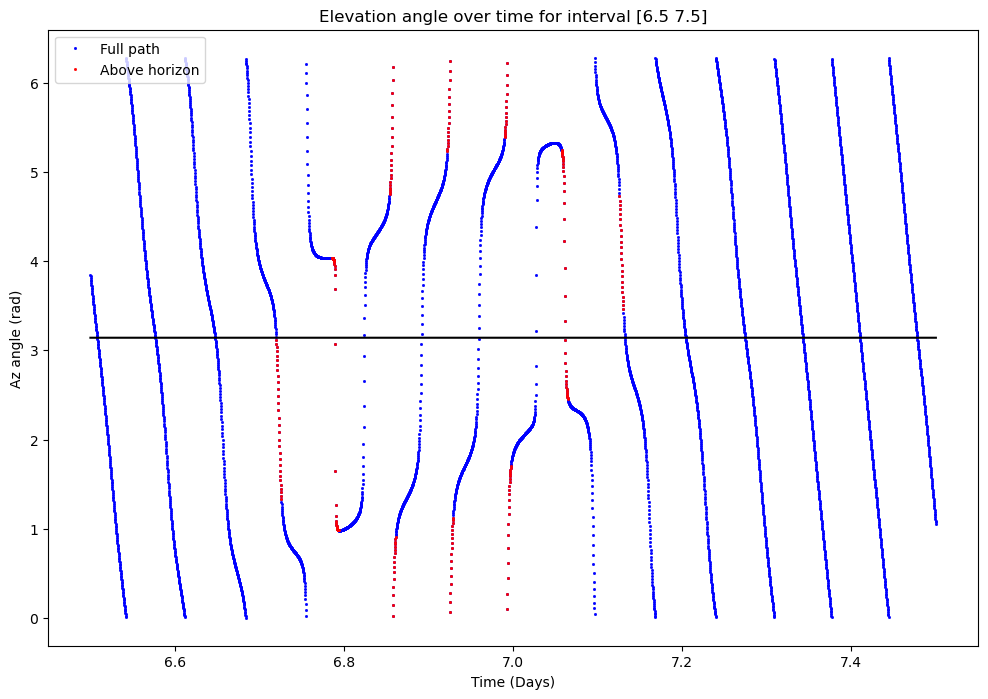

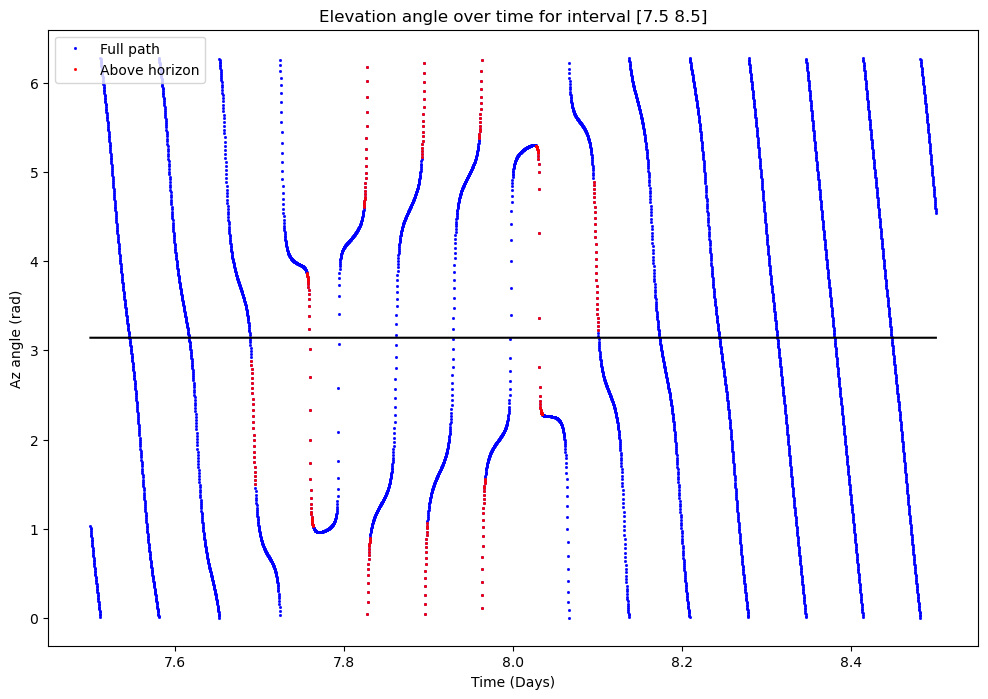

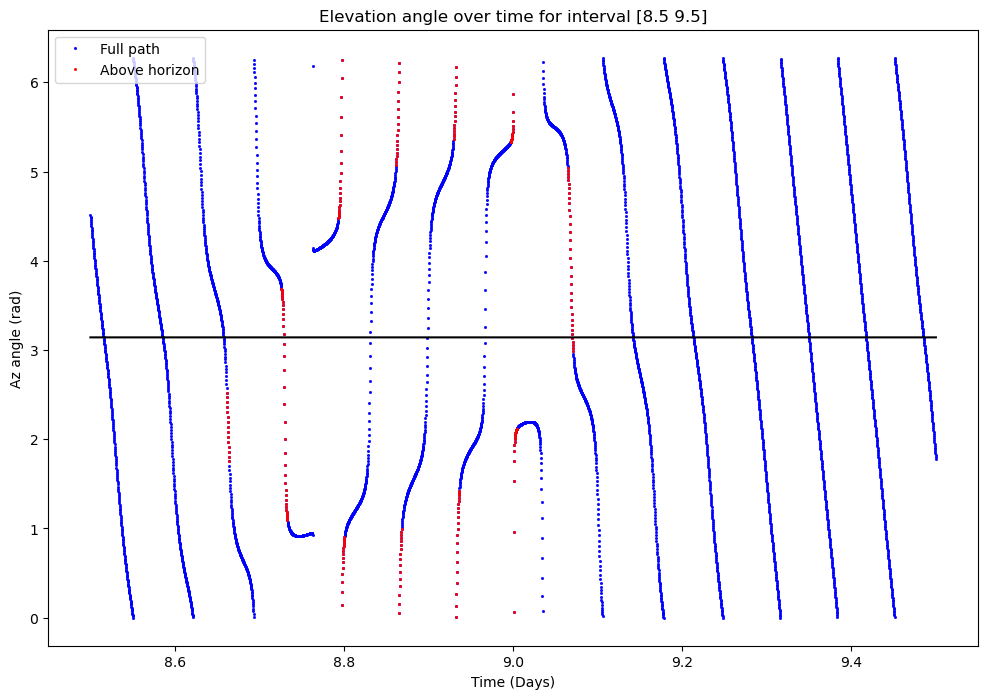

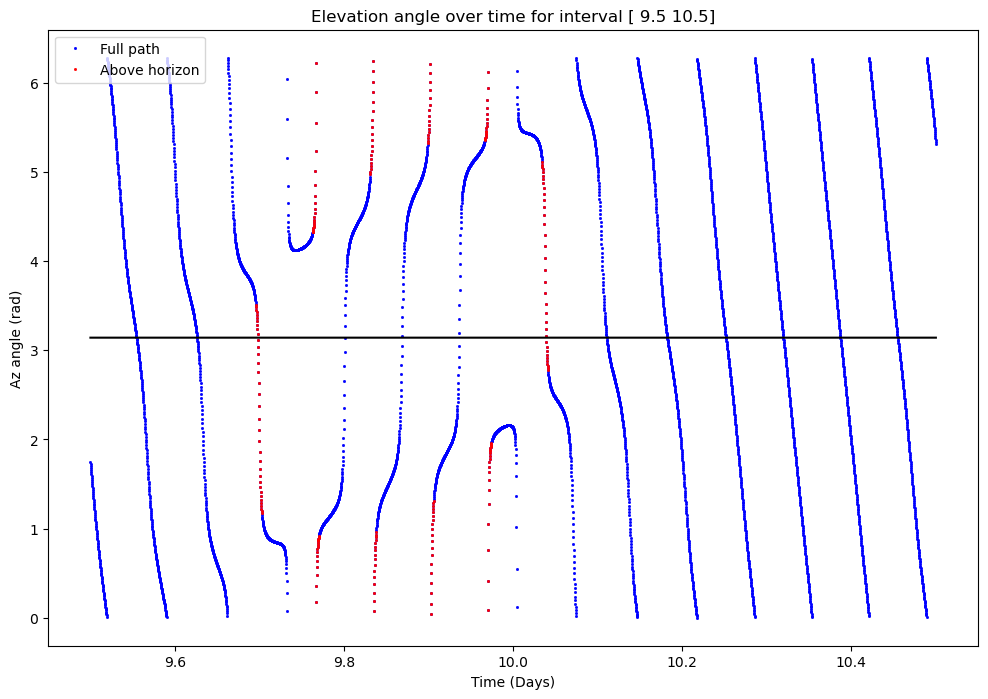

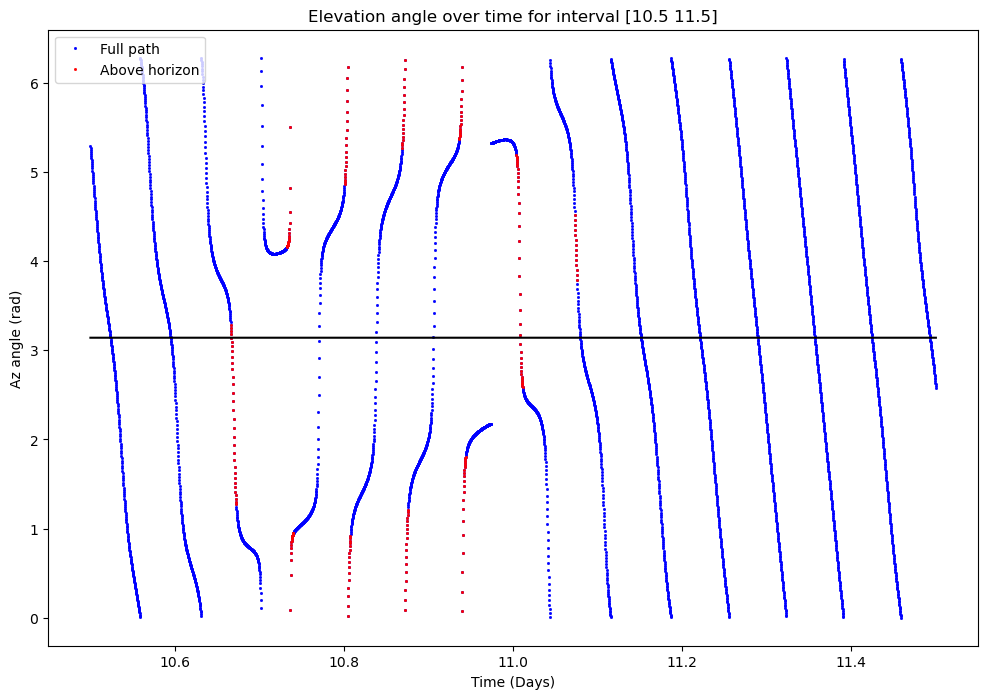

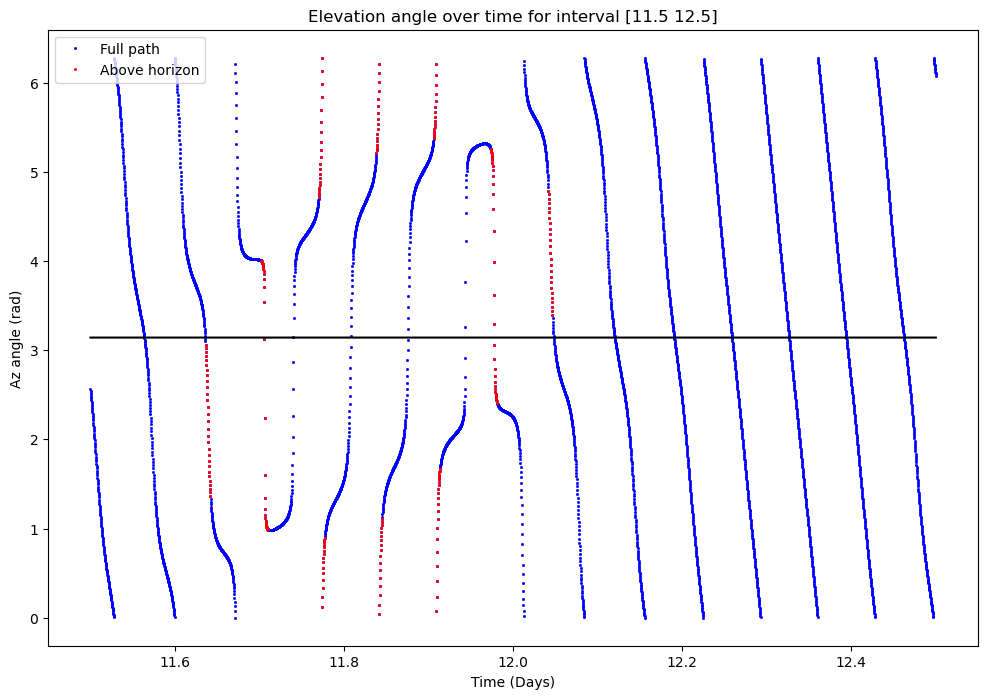

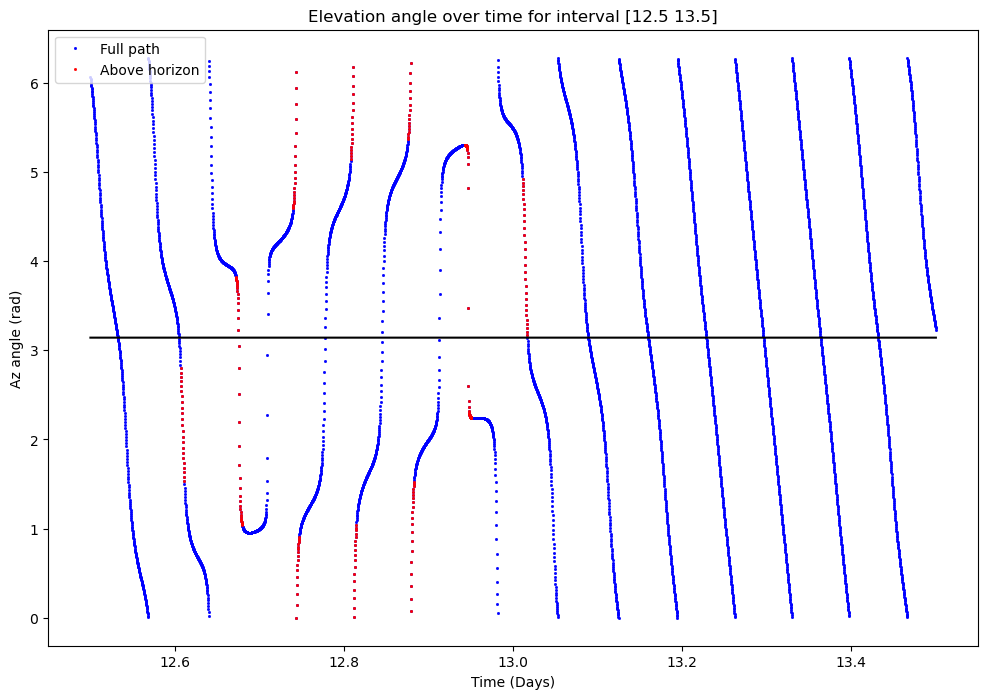

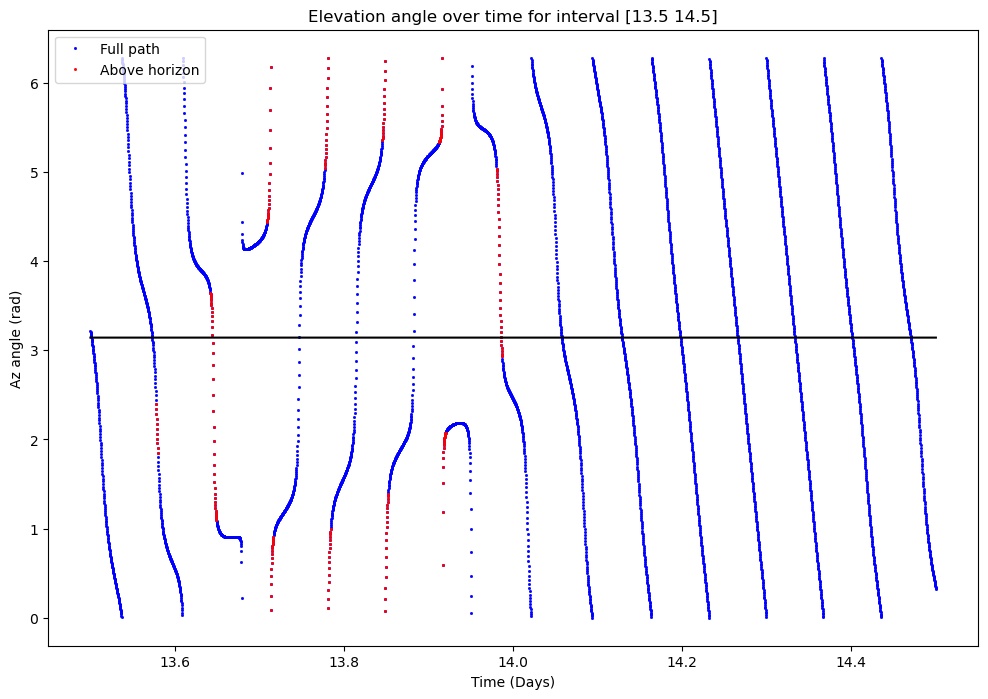

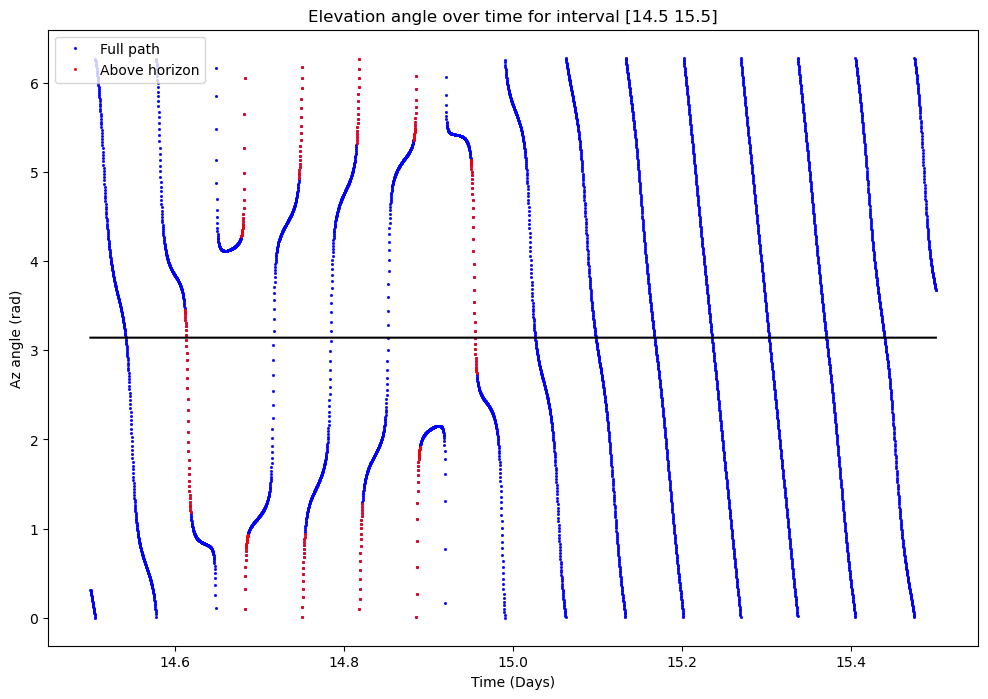

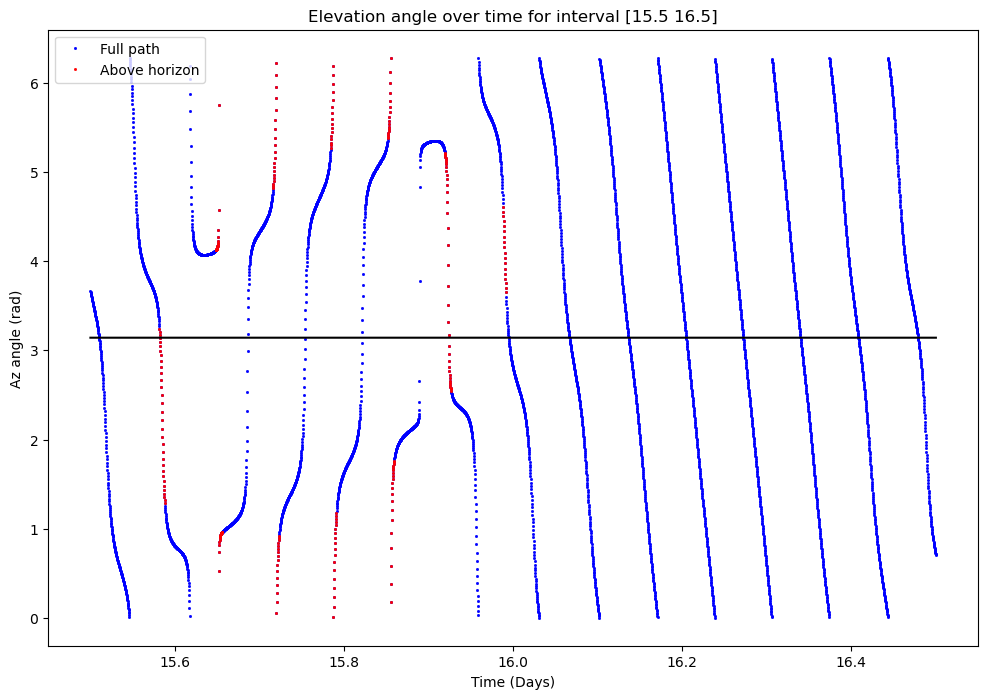

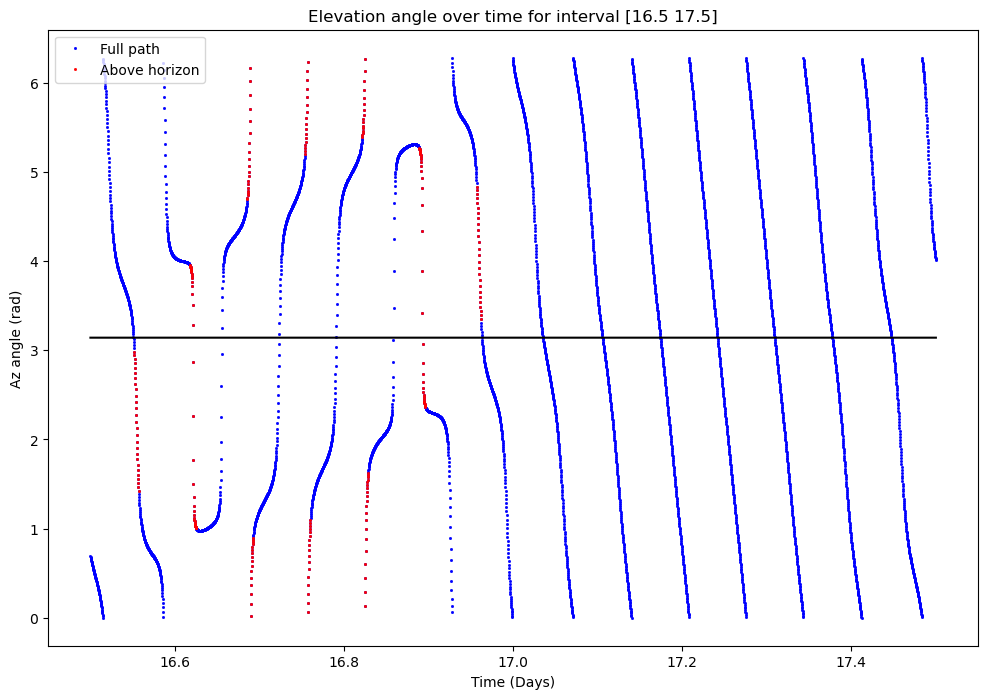

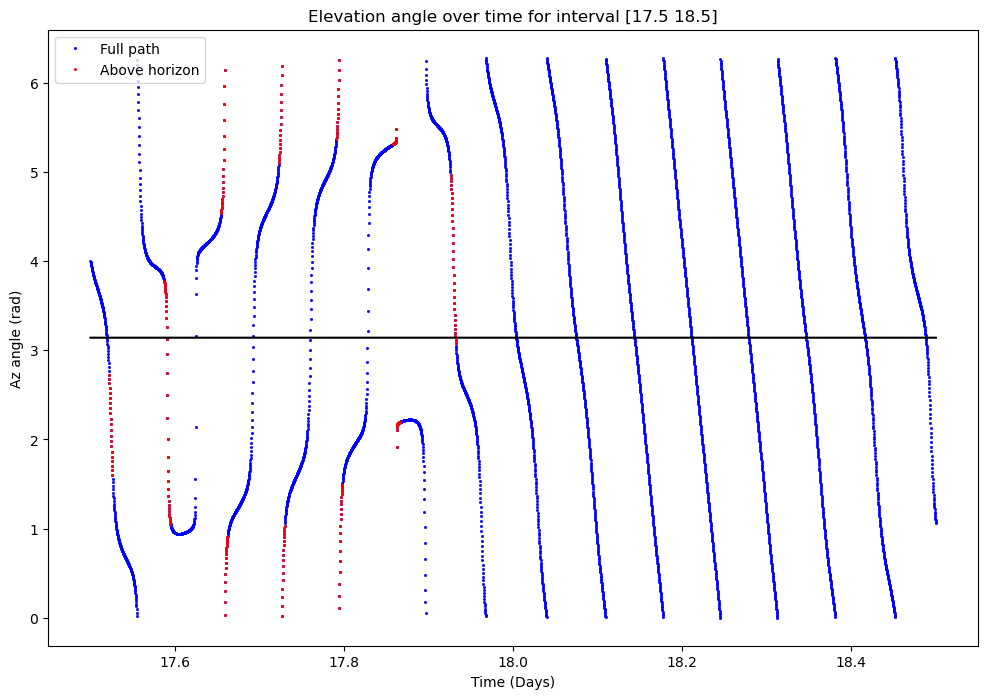

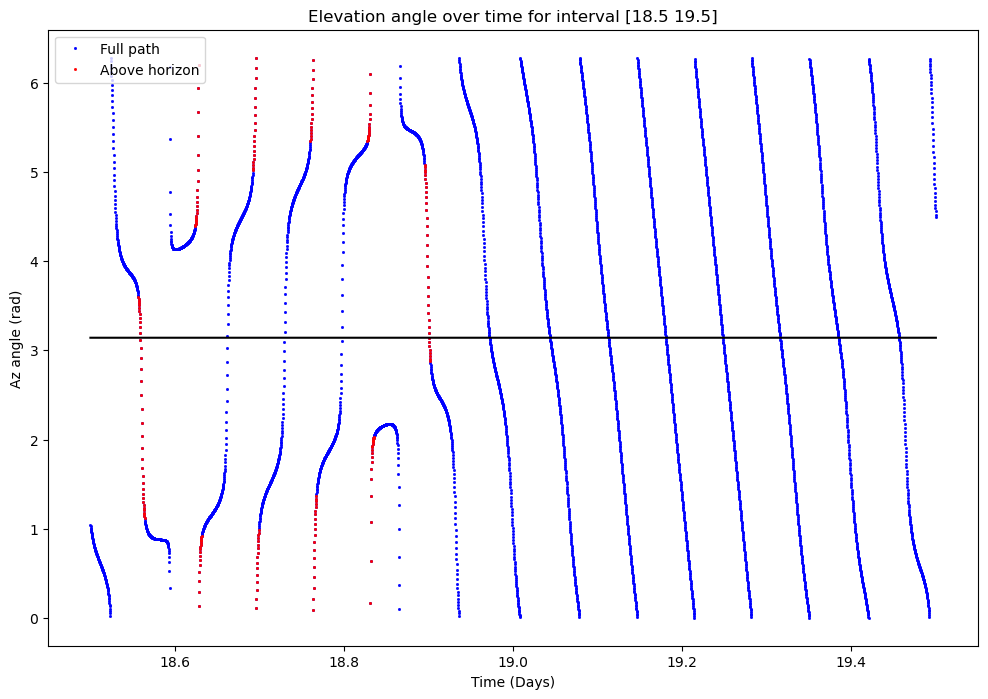

In [32]:
aboce_horizon_az=np.ma.masked_array(altaz.az.rad,mask=above_horizon_mask)
with quantity_support() and time_support():
    
    intervals_start=0.5+np.arange(19)
    intervals_end=1.5+np.arange(19)
    intervals=np.stack((intervals_start,intervals_end),axis=1)
    #print(intervals)
    above_horizon=np.ma.masked_less(altaz.alt.deg,0)
    above_horizon_mask=np.ma.getmask(above_horizon)
    above_horizon_az=np.ma.masked_array(altaz.az.rad,mask=above_horizon_mask)
    for interval in intervals:
        plt.figure(figsize=(12,8))
       
        boolean_arr=(numpy_time_delta>(np.ones_like(numpy_time_delta))*interval[0]) * ((np.ones_like(numpy_time_delta)*numpy_time_delta)<interval[1])
        plt.plot(numpy_time_delta[boolean_arr],altaz.az.rad[boolean_arr],'bs',ms=1,label='Full path')
        plt.plot(numpy_time_delta[boolean_arr],above_horizon_az[boolean_arr],'rs',ms=1,label='Above horizon')

        plt.plot(numpy_time_delta[boolean_arr],(np.pi)*np.ones(len(numpy_time_delta[boolean_arr])),'k')
        plt.title(f"Elevation angle over time for interval {interval}")
        plt.xlabel("Time (Days)")
        plt.ylabel("Az angle (rad)")
        plt.legend(loc='upper left')
        plt.show()
 


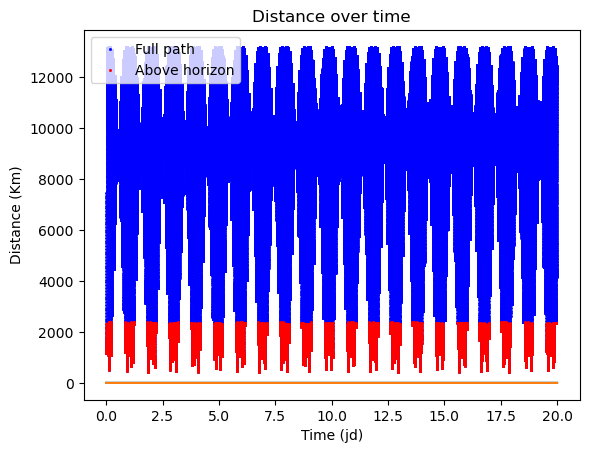

In [33]:
with quantity_support() and time_support(format='mjd',simplify=True):
    plt.plot(numpy_time_delta,altaz.distance,'bs',ms=1,label='Full path')
    plt.plot(numpy_time_delta,np.ma.masked_array(altaz.distance,mask=above_horizon_mask),'rs',ms=1,label='Above horizon')
    plt.plot(numpy_time_delta,np.pi*np.ones(len(times)))
    plt.plot(numpy_time_delta,-np.pi*np.ones(len(times)))
    plt.title("Distance over time")
    plt.xlabel("Time (jd)")
    plt.ylabel("Distance (Km)")
    plt.legend(loc='upper left')
    plt.show()